In [ ]:
!pip install datasets


     |████████████████████████████████| 342 kB 8.7 MB/s 
     |████████████████████████████████| 212 kB 73.5 MB/s 
     |████████████████████████████████| 136 kB 71.5 MB/s 
     |████████████████████████████████| 1.1 MB 77.9 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 127 kB 80.1 MB/s 
     |████████████████████████████████| 144 kB 82.4 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 271 kB 73.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# !pip install torch==1.7.0
# !pip install torchtext==0.10.0

     |████████████████████████████████| 7.6 MB 26.9 MB/s 
     |████████████████████████████████| 831.4 MB 2.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.8.0
    Uninstalling torchtext-0.8.0:
      Successfully uninstalled torchtext-0.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.
textattack 0.3.0 requires numpy<1.19.0, but you have numpy 1.21.6 which is incompatible.
textattack 0.3.0 requires torch==1.7.1, but you have torch 1.9.0 which is incompatible.


In [ ]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


# df_train = pd.read_csv("language_train.csv")
# df_test = pd.read_csv("language_test.csv")

df_train = pd.read_csv("reuters_8_class_train_final.csv")
df_test = pd.read_csv("reuters_8_class_test_final.csv")

df_train

,text,class,label
0,computer terminal systems cpml completes sale ...,ac,0
1,chemlawn chem rises on hopes for higher bids c...,ac,0
2,cofab inc buys gulfex for undisclosed amount c...,ac,0
3,investment firms cut cyclops cyl stake a group...,ac,0
4,american express axp seen in possible spinnoff...,ac,0
...,...,...,...
5480,volcker urges quick aid to debtor nations fede...,tr,7
5481,volcker pushes spending cuts over trade bill f...,tr,7
5482,japan cuts chip supply may produce shortage ja...,tr,7
5483,u s urges surplus nations to boost growth lead...,tr,7


In [ ]:
# df_train = df_train.rename({'class':'label'}, axis='columns')
# df_test = df_test.rename({'class':'label'}, axis='columns')
# df_test

,Unnamed: 0,text,label,label
0,0,sumitomo bank aims at quick recovery from merg...,ac,0
1,1,cra sold forrest gold for mln dlrs whim creek ...,ac,0
2,2,conrac cax in merger talks with several conrac...,ac,0
3,3,polycast ptcc reduces spartech sptn stake poly...,ac,0
4,4,hospital corp says it received dlr a share off...,ac,0
...,...,...,...,...
2196,2196,u s house speaker denies trade bill hurt stock...,tr,7
2197,2197,cairns group said influential in trade talks a...,tr,7
2198,2198,philippine trade gap widens in january august ...,tr,7
2199,2199,soviet trade deficit with west soars in the so...,tr,7


In [ ]:
import functools
import sys

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
from datasets import Dataset

seed = 0

torch.manual_seed(seed)

In [ ]:
train_data = Dataset.from_pandas(df_train)
test_data = Dataset.from_pandas(df_test)

In [ ]:
test_data

Dataset({
    features: ['text', 'class', 'label'],
    num_rows: 2201
})

In [ ]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
def tokenize_data(example, tokenizer, max_length):
    tokens = tokenizer(example['text'])[:max_length]
    length = len(tokens)
    return {'tokens': tokens, 'length': length}

max_length = 256

train_data = train_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})
test_data = test_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})

test_size = 0.25

# train_valid_data = train_data.train_test_split(test_size=test_size)
# train_data = train_valid_data['train']
valid_data = test_data

min_freq = 5
special_tokens = ['<unk>', '<pad>']

vocab = torchtext.vocab.build_vocab_from_iterator(train_data['tokens'],
                                                  min_freq=min_freq,
                                                  specials=special_tokens)

unk_index = vocab['<unk>']
pad_index = vocab['<pad>']

vocab.set_default_index(unk_index)
def numericalize_data(example, vocab):
    ids = [vocab[token] for token in example['tokens']]
    return {'ids': ids}

train_data = train_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
valid_data = valid_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
test_data = test_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
print(test_data)
train_data = train_data.with_format(type='torch', columns=['ids', 'label', 'length'])
valid_data = valid_data.with_format(type='torch', columns=['ids', 'label', 'length'])
test_data = test_data.with_format(type='torch', columns=['ids', 'label', 'length'])

train_data[0]


  0%|          | 0/5485 [00:00<?, ?ex/s]

  0%|          | 0/2201 [00:00<?, ?ex/s]

  0%|          | 0/5485 [00:00<?, ?ex/s]

  0%|          | 0/2201 [00:00<?, ?ex/s]

  0%|          | 0/2201 [00:00<?, ?ex/s]

Dataset({
    features: ['text', 'class', 'label', 'tokens', 'length', 'ids'],
    num_rows: 2201
})


{'ids': tensor([ 413, 1832,  232,    0,  604,   93,  413, 1832,  232,   25,    7,   13,
           37,  291,    2,   93,    3,   41,    3,   19,   85,   51,    9,  901,
            4,  180,   42,  428,   53,    8,   41,    4,    0,  378, 1781,    3,
            0, 2365,   14,   11,    2,   24,    7,    2,  901,   76, 2405,   14,
          108,  233,   35,    6,  196,  131,    3,   11,   68,   36,  413, 1832,
            7,    0,   65,   37,    2,  580,    4,  132,  428,   41,    9,  159,
           19,  138,  336,   88,    4,   22,    3,    2,  413, 1832,   15,  170,
           85,   51,  134,  408, 1787, 2145,  448,    3,  304,   35,    2,   24,
            2,   24,    7,  136,    2,  559, 2631,    2,  901,   47,   33, 2405,
           35,    6,  131, 1182,    4,   22,    3,   19,   85,   51,   15,   81,
          131,   35,    2,  221,   49,    4, 1207,   11,   68,   36,  413, 1832,
           65,    7,   13,  284,    2,    0,  449,    4,   19, 1418,    0,  846,
          527,  332, 

In [ ]:
train_data

Dataset({
    features: ['text', 'class', 'label', 'tokens', 'length', 'ids'],
    num_rows: 5485
})

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional,
                 dropout_rate, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional,
                            dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
    
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, length, batch_first=True, 
                                                            enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [ ]:
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 100
output_dim = len(train_data.unique('label'))
n_layers = 2
bidirectional = True
dropout_rate = 0.3

model = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate, 
             pad_index)

In [ ]:
output_dim = len(train_data.unique('label'))
output_dim

8

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,009,508 trainable parameters


In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [ ]:
model.apply(initialize_weights)
# model.init_weights()

LSTM(
  (embedding): Embedding(6047, 100, padding_idx=1)
  (lstm): LSTM(100, 100, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=200, out_features=8, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
vectors = torchtext.vocab.GloVe(name='6B', dim=100)
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
model.embedding.weight.data = pretrained_embedding

.vector_cache/glove.6B.zip: 862MB [02:39, 5.39MB/s]                           
100%|█████████▉| 399999/400000 [00:13<00:00, 29638.02it/s]


In [ ]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
# vectors = torchtext.vocab.FastText()
# pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
# model.embedding.weight.data = pretrained_embedding
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)
def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_length = [i['length'] for i in batch]
    batch_length = torch.stack(batch_length)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'length': batch_length,
             'label': batch_label}
    return batch

batch_size = 512
collate = functools.partial(collate, pad_index=pad_index)
train_dataloader = torch.utils.data.DataLoader(train_data, 
                                               batch_size=batch_size, 
                                               collate_fn=collate, 
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        length = batch['length']
        label = batch['label'].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = categorical_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

def evaluate(dataloader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            length = batch['length']
            label = batch['label'].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = categorical_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs


def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

best_valid_loss = float('inf')



In [ ]:
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
n_epochs = 30

for epoch in range(n_epochs):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)
    
    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)
    
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'lstm.pt')
    
    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

evaluating...: 100%|██████████| 5/5 [00:00<00:00,  6.77it/s]
epoch: 1
train_loss: 1.869, train_acc: 0.471
valid_loss: 1.680, valid_acc: 0.423
evaluating...: 100%|██████████| 5/5 [00:00<00:00,  6.79it/s]
epoch: 2
train_loss: 1.354, train_acc: 0.531
valid_loss: 1.461, valid_acc: 0.594
evaluating...: 100%|██████████| 5/5 [00:00<00:00,  6.89it/s]
epoch: 3
train_loss: 1.067, train_acc: 0.631
valid_loss: 1.094, valid_acc: 0.624
evaluating...: 100%|██████████| 5/5 [00:00<00:00,  6.79it/s]
epoch: 4
train_loss: 0.852, train_acc: 0.713
valid_loss: 0.946, valid_acc: 0.669
evaluating...: 100%|██████████| 5/5 [00:00<00:00,  6.73it/s]
epoch: 5
train_loss: 0.704, train_acc: 0.750
valid_loss: 0.787, valid_acc: 0.687
evaluating...: 100%|██████████| 5/5 [00:00<00:00,  6.73it/s]
epoch: 6
train_loss: 0.549, train_acc: 0.799
valid_loss: 0.693, valid_acc: 0.766
evaluating...: 100%|██████████| 5/5 [00:00<00:00,  6.84it/s]
epoch: 7
train_loss: 0.473, train_acc: 0.841
valid_loss: 0.606, valid_acc: 0.794
evalua

Text(0, 0.5, 'loss')

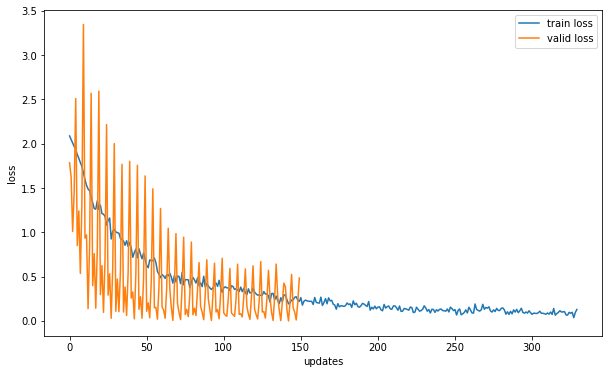

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

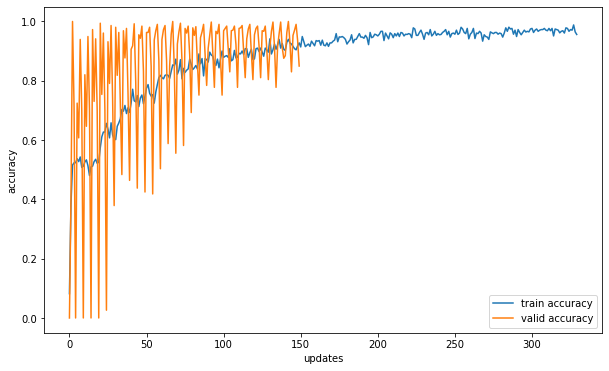

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');

In [ ]:
model.load_state_dict(torch.load('lstm.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

evaluating...: 100%|██████████| 5/5 [00:00<00:00,  6.80it/s]
test_loss: 0.191, test_acc: 0.940


In [ ]:
df_attack = pd.read_csv("hd_8_classes_attack_textfooler_new_window_4.csv")

df_attack = df_attack[df_attack['result_type'] == 'Successful']
df_attack = df_attack[['perturbed_text', 'ground_truth_output', 'original_text']]
df_attack = df_attack.rename(columns={'perturbed_text': 'text', 'ground_truth_output': 'label'})

def filter_data(input):
    input = input.replace("[[", "")
    input = input.replace("]]", "")
    return input

df_attack['text'] = df_attack['text'].apply(filter_data)
df_attack['original_text'] = df_attack['original_text'].apply(filter_data)




In [ ]:
df_attack['adv_pred'] = df_attack['text'].apply(predict_class_adv)
df_attack['adv_pred_org'] = df_attack['original_text'].apply(predict_class_adv)

df_attack

,text,label,original_text,adv_pred,adv_pred_org
0,blount serv blt gerardo qtr net oper shr secre...,2,blount inc blt th qtr net oper shr cts vs thre...,2,2
1,gorman rupp co grc sets quarterly qtly int sec...,2,gorman rupp co grc sets quarterly qtly div cts...,2,2
3,wesbanco wsbc o acquiring bank of sissonville ...,0,wesbanco wsbc o acquiring bank of sissonville ...,0,0
4,pepsico unit pep lifts calny o stake taco bell...,0,pepsico unit pep lifts calny o stake taco bell...,0,0
5,malaysia advised to raise disrespectful hydroc...,1,malaysia advised to raise crude oil output in ...,1,1
...,...,...,...,...,...
195,ibc s interstate bakeries ibc bid oversubscrib...,0,ibc s interstate bakeries ibc bid oversubscrib...,0,0
196,venezuela says opec hydrocarbons results ver m...,1,venezuela says opec oil output ver mln bpd car...,1,1
197,society savings socs o types remembrance socie...,0,society savings socs o forms holding company s...,2,0
198,average japanese cd proportions reductions in ...,5,average yen cd rates fall in latest week avera...,5,5


In [ ]:
df_attack['label'].values
# df_test['target']
np.mean(df_attack['adv_pred'] == df_attack['label'])

0.8716216216216216

In [ ]:
df_attack['label'].values
# df_test['target']
np.mean(df_attack['adv_pred_org'] == df_attack['label'])

0.9391891891891891

In [ ]:
def predict_class(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = [vocab[t] for t in tokens]
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability


In [ ]:
def predict_class_adv(text):
    tokens = tokenizer(text)
    ids = [vocab[t] for t in tokens]
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class

In [ ]:
text = "Odobrenieto na motorni prevozni sredstva po"

predict_class(text, model, tokenizer, vocab, device)

(7, 0.8278788924217224)

In [ ]:
!pip install textattack
!pip install tensorflow_text

     |████████████████████████████████| 373 kB 30.8 MB/s 
     |████████████████████████████████| 60 kB 8.5 MB/s 
     |████████████████████████████████| 769 kB 73.2 MB/s 
     |████████████████████████████████| 101 kB 14.9 MB/s 
     |████████████████████████████████| 69 kB 9.3 MB/s 
     |████████████████████████████████| 401 kB 97.4 MB/s 
     |████████████████████████████████| 4.0 MB 85.6 MB/s 
     |████████████████████████████████| 596 kB 80.5 MB/s 
     |████████████████████████████████| 6.6 MB 68.3 MB/s 
     |████████████████████████████████| 895 kB 54.4 MB/s 
     |████████████████████████████████| 325 kB 56.2 MB/s 
     |████████████████████████████████| 312 kB 64.4 MB/s 
     |████████████████████████████████| 311 kB 77.7 MB/s 
     |████████████████████████████████| 312 kB 99.0 MB/s 
     |████████████████████████████████| 311 kB 98.9 MB/s 
     |████████████████████████████████| 311 kB 102.5 MB/s 
     |████████████████████████████████| 306 kB 89.9 MB/s 
     |███████████

     |████████████████████████████████| 4.9 MB 36.3 MB/s 
     |████████████████████████████████| 462 kB 78.9 MB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.1
    Uninstalling importlib-metadata-3.10.1:
      Successfully uninstalled importlib-metadata-3.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
konoha 4.6.5 requires importlib-metadata<4.0.0,>=3.7.0, but you have importlib-metadata 4.11.3 which is incompatible.


In [ ]:
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
# predictions = model.predict(["The movie was not good. The animation and the graphics"])
import textattack

import numpy as np
import torch
from textattack.models.wrappers import ModelWrapper

class CustomPytorchModelWrapper(ModelWrapper):
    def __init__(self, model, tokenizer, vocab):
        self.model = model
        self.tokenizer = tokenizer
        self.vocab = vocab
    def __call__(self, text_input_list):
        probabilities = []
        for text in text_input_list:
          tokens = tokenizer(text)
          ids = [vocab[t] for t in tokens]
          length = torch.LongTensor([len(ids)])
          tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
          prediction = model(tensor, length).squeeze(dim=0)
          probability = torch.softmax(prediction, dim=-1)
          probability = probability.cpu().detach().numpy()
          probabilities.append(probability)
        return probabilities

model_wrapper = CustomPytorchModelWrapper(model, tokenizer, vocab)

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/paragramcf.
100%|██████████| 481M/481M [00:39<00:00, 12.0MB/s]
textattack: Unzipping file /root/.cache/textattack/tmpap_p7xoi.zip to /root/.cache/textattack/word_embeddings/paragramcf.
textattack: Successfully saved word_embeddings/paragramcf to cache.


In [ ]:
import textattack
df_attack = pd.read_csv("attack_dataset_8_classes_1.csv")

data = []
for index, row in df_attack.iterrows():
    data.append((row['text'], row['label']))

df_attack_2 = pd.read_csv("attack_dataset_8_classes_2.csv")
for index, row in df_attack_2.iterrows():
    data.append((row['text'], row['label']))
    
dataset = textattack.datasets.Dataset(data)

In [ ]:
from textattack.attack_recipes import TextFoolerJin2019, PWWSRen2019, DeepWordBugGao2018, GeneticAlgorithmAlzantot2018
from textattack import Attacker
from textattack import AttackArgs

# dataset = custom_dataset
attack = DeepWordBugGao2018.build(model_wrapper)
attack_args = AttackArgs(num_examples=200, log_to_csv="lstm_attack_deepwordbug_8_classes_pre_trained.csv")
attacker = Attacker(attack, dataset, attack_args)
attacker.attack_dataset()

textattack: Unknown if model of class <class '__main__.LSTM'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path lstm_attack_deepwordbug_8_classes_pre_trained.csv


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  30
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:   1%|          | 2/200 [00:01<01:47,  1.84it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

blount inc blt th qtr net oper shr cts vs three cts oper net vs revs mln vs mln avg shrs mln vs mln year oper shr cts vs cts oper net vs revs billion vs billion avg shrs mln vs mln note prior year net excludes gains dlrs in quarter and dlrs in year from termination of overfunded pension plans backlog billion dlrs vs mln dlrs reuter 


--------------------------------------------- Result 2 ---------------------------------------------
[[2 (100%)]] --> [[5 (47%)]]

gorman rupp [[co]] grc sets [[quarterly]] qtly [[div]] [[cts]] [[vs]] [[cts]] prior [[pay]] june record may eight [[reuter]] 

gorman rupp [[c]] grc sets [[quartely]] qtly [[Pdiv]] [[Ucts]] [[s]] [[Rts]] prior [[ray]] june record may eight [[retuer]] 




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:   2%|▏         | 3/200 [00:01<01:31,  2.15it/s]

--------------------------------------------- Result 3 ---------------------------------------------
[[2 (94%)]] --> [[0 (64%)]]

international thomson to [[report]] in u s funds international thomson organisation ltd said it will [[report]] financial [[results]] in u s funds rather than sterling beginning from jan it said the change will not be applied retroactively to prior financial periods the company said as a result of recent investments most of its assets now are located in the united states reuter 

international thomson to [[reort]] in u s funds international thomson organisation ltd said it will [[Ireport]] financial [[resulGs]] in u s funds rather than sterling beginning from jan it said the change will not be applied retroactively to prior financial periods the company said as a result of recent investments most of its assets now are located in the united states reuter 




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:   2%|▏         | 4/200 [00:01<01:34,  2.07it/s]

--------------------------------------------- Result 4 ---------------------------------------------
[[0 (100%)]] --> [[6 (54%)]]

wesbanco wsbc o [[acquiring]] [[bank]] of sissonville wesbanco [[inc]] [[said]] its [[board]] executed a [[merger]] [[agreement]] with the bank of sissonville when the [[merger]] is completed each of the [[shares]] of the bank of sissonville common stock outstanding will be converted into [[shares]] of wesbanco common [[stock]] the company said the [[bank]] of sissonville has total [[assets]] of [[mln]] [[dlrs]] as of [[dec]] the [[company]] [[said]] reuter 

wesbanco wsbc o [[Wcquiring]] [[Fank]] of sissonville wesbanco [[iGc]] [[Gaid]] its [[Xboard]] executed a [[jmerger]] [[agreeVment]] with the bank of sissonville when the [[meger]] is completed each of the [[Vshares]] of the bank of sissonville common stock outstanding will be converted into [[shaPres]] of wesbanco common [[Pstock]] the company said the [[Cbank]] of sissonville has total [[asseks]] of 

[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:   2%|▎         | 5/200 [00:02<01:39,  1.97it/s]

--------------------------------------------- Result 5 ---------------------------------------------
[[0 (100%)]] --> [[5 (35%)]]

[[pepsico]] [[unit]] pep lifts calny o [[stake]] taco [[bell]] [[corp]] a unit of [[pepsico]] [[inc]] said it increased its [[stake]] in calny [[inc]] common stock to [[shares]] or pct of the total outstanding from a previous figure of approximately [[shares]] or pct in a filing with the securities and [[exchange]] commission taco [[bell]] said it [[bought]] calny common [[shares]] on october and at [[dlrs]] a share no reason was given for the recent [[purchases]] reuter 

[[pepsiIco]] [[nit]] pep lifts calny o [[stakp]] taco [[Sbell]] [[crop]] a unit of [[epsico]] [[Tinc]] said it increased its [[stEake]] in calny [[Iinc]] common stock to [[hares]] or pct of the total outstanding from a previous figure of approximately [[sahres]] or pct in a filing with the securities and [[exchaneg]] commission taco [[bTell]] said it [[bXought]] calny common [[hsares]] on

[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:   3%|▎         | 6/200 [00:03<02:02,  1.58it/s]

--------------------------------------------- Result 6 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

malaysia advised to raise crude oil output in malaysia s national oil company petronas has advised the government to raise crude oil output to barrels a day bpd in from a current bpd a senior company official said we have the capacity to produce the amount rastam hadi petronas s vice president for upstream sector said the government will announce its decision on friday when it unveils the country s budget malaysia raised output this month to current levels from bpd after reviewing the world oil market in may malaysia cut output to bpd from in response to a call by opec to boost prices reuter 




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:   4%|▎         | 7/200 [00:12<05:51,  1.82s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[5 (88%)]] --> [[[FAILED]]]

u s bill auction rates average pct the u s treasury said its weekly auction of three month bills produced an average rate of pct with a pct rate on six month bills these rates compared with averages of pct for the three and pct for the six month bills sold last week the bond equivalent yield on three month bills was pct accepted bids ranges from to pct and pct of the bids at the high or stopout rate were taken for six months the yield was pct and the bids ranged from pct to pct with pct of the bids accepted the treasury said it received billion dlrs of bids for the three month bills including billion dlrs in non competitive bids from the public it accepted billion dlrs of bids including billion dlrs from the federal reserve and mln dlrs from foreign and international monetary authorities some billion dlrs in bids for six month bills were received including 

[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:   4%|▍         | 8/200 [00:13<05:18,  1.66s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[2 (100%)]] --> [[5 (51%)]]

gateway [[federal]] [[savings]] gatw o [[rd]] [[qtr]] [[net]] shr [[cts]] vs not given [[net]] vs not given nine mths shr dlrs vs not given [[net]] vs not given note full name is gateway federal savings and loan association latest [[qtr]] includes a tax credit of dlrs or cents a [[share]] latest nine mths includes a tax credit of [[dlrs]] or [[dlrs]] figures not given as [[company]] [[went]] [[public]] on [[june]] [[reuter]] 

gateway [[fdeeral]] [[saEvings]] gatw o [[Xd]] [[qsr]] [[ne]] shr [[nts]] vs not given [[het]] vs not given nine mths shr dlrs vs not given [[ent]] vs not given note full name is gateway federal savings and loan association latest [[bqtr]] includes a tax credit of dlrs or cents a [[Lshare]] latest nine mths includes a tax credit of [[Alrs]] or [[dlWrs]] figures not given as [[compiany]] [[Fent]] [[pubHlic]] on [[Rune]] [[reueter]] 




[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:   4%|▍         | 9/200 [00:13<04:47,  1.51s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[2 (100%)]] --> [[5 (57%)]]

kent [[electronics]] [[corp]] kec nd [[qtr]] sept [[net]] [[shr]] [[cts]] vs seven [[cts]] [[net]] vs revs vs avg shrs vs [[nine]] mths [[shr]] [[cts]] [[vs]] [[cts]] [[net]] [[vs]] revs [[mln]] [[vs]] avg shrs [[vs]] [[reuter]] 

kent [[eDlectronics]] [[Dcorp]] kec nd [[qts]] sept [[ent]] [[hsr]] [[Vts]] vs seven [[ccts]] [[nKet]] vs revs vs avg shrs vs [[Dnine]] mths [[shE]] [[cHts]] [[s]] [[cs]] [[ne]] [[Pvs]] revs [[Gmln]] [[sv]] avg shrs [[Cs]] [[rXuter]] 




[Succeeded / Failed / Skipped / Total] 7 / 3 / 0 / 10:   5%|▌         | 10/200 [00:17<05:24,  1.71s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[7 (90%)]] --> [[6 (28%)]]

u s weighs [[lifting]] [[japanese]] [[trade]] [[curbs]] the [[white]] house has completed a new [[review]] of [[japanese]] semiconductor trading practices but has not yet decided whether trade sanctions levied against japan last april should be lifted u s officials said they said the president s economic policy council looked at japan s adherence to the u s japanese semiconductor pact yesterday and that an announcement may be made shortly but there was no hint what the announcement might be officials have said the pct tariffs on mln dlrs of japanese exports could be modified if japan was found to be honoring a portion of its semiconductor pact but they also noted that the white house has said it was unlikely the tariffs would be lifted before the meeting of the world s seven major economic powers in venice on june the officials added that while the curbs co

[Succeeded / Failed / Skipped / Total] 9 / 3 / 0 / 12:   6%|▌         | 12/200 [00:17<04:37,  1.47s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[4 (77%)]] --> [[7 (52%)]]

white house says u s [[monetary]] policy correct the white house distancing itself from remarks by the administration s budget chief said the federal reserve s current course of monetary policy was appropriate the administration feels that the current course of monetary policy is appropriate white house spokesman marlin fitwater said fitzwater said the administration did not endorse remarks by white house budget chief james miller who said he was concerned the federal reserve might overreact to the decline in the [[value]] of the u s dollar by raising interest rates more 

white house says u s [[moentary]] policy correct the white house distancing itself from remarks by the administration s budget chief said the federal reserve s current course of monetary policy was appropriate the administration feels that the current course of monetary policy is appropri

[Succeeded / Failed / Skipped / Total] 10 / 3 / 1 / 14:   7%|▋         | 14/200 [00:17<03:57,  1.28s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[2 (100%)]] --> [[5 (49%)]]

[[general]] [[electric]] [[co]] [[ge]] st [[qtr]] [[net]] shr dlrs vs dlrs [[net]] mln vs mln [[sales]] billion vs billion note prior [[year]] does not [[include]] [[results]] of rca [[corp]] [[reuter]] 

[[egneral]] [[Llectric]] [[Jo]] [[Lge]] st [[qOtr]] [[ne]] shr dlrs vs dlrs [[ent]] mln vs mln [[pales]] billion vs billion note prior [[yea]] does not [[incflude]] [[esults]] of rca [[cJrp]] [[Leuter]] 


--------------------------------------------- Result 14 ---------------------------------------------
[[1 (87%)]] --> [[[SKIPPED]]]

rio de janeiro dockers strike rio de janeiro s dockworkers went on strike for an indefinite period today to demand wage increases a spokesman for the dockers said the rio dockers did not get support from their colleagues in santos brazil s main port but the spokesman said they would not return to work unless their demands 

[Succeeded / Failed / Skipped / Total] 11 / 3 / 1 / 15:   8%|▊         | 15/200 [00:18<03:43,  1.21s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[2 (100%)]] --> [[6 (17%)]]

helene curtis [[industries]] [[inc]] hc [[st]] [[qtr]] [[net]] period end may [[shr]] [[profit]] four [[cts]] [[vs]] [[loss]] [[cts]] [[net]] [[profit]] [[vs]] [[loss]] revs [[mln]] [[vs]] [[mln]] [[reuter]] 

helene curtis [[idustries]] [[Dnc]] hc [[Rt]] [[qBr]] [[Wet]] period end may [[hsr]] [[profiRt]] four [[cs]] [[s]] [[los]] [[cSs]] [[Aet]] [[pqofit]] [[Nvs]] [[loRss]] revs [[mXln]] [[sv]] [[mRln]] [[reKuter]] 




[Succeeded / Failed / Skipped / Total] 12 / 3 / 1 / 16:   8%|▊         | 16/200 [00:18<03:33,  1.16s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[2 (100%)]] --> [[6 (33%)]]

eastek [[corp]] estk o [[st]] [[qtr]] sept [[loss]] [[shr]] [[loss]] [[cts]] [[vs]] [[loss]] four cts [[net]] [[loss]] [[vs]] [[loss]] revs [[vs]] not available [[note]] the [[company]] made its [[initial]] [[offering]] in [[march]] and before then had been a development stage [[company]] so no [[sales]] were [[posted]] in [[reuter]] 

eastek [[Zcorp]] estk o [[Qt]] [[Htr]] sept [[loms]] [[hr]] [[los]] [[ccs]] [[s]] [[floss]] four cts [[Tnet]] [[lEoss]] [[s]] [[los]] revs [[jvs]] not available [[notA]] the [[comfany]] made its [[iRnitial]] [[fofering]] in [[arch]] and before then had been a development stage [[ccompany]] so no [[saels]] were [[posed]] in [[reute]] 




[Succeeded / Failed / Skipped / Total] 13 / 3 / 1 / 17:   8%|▊         | 17/200 [00:18<03:22,  1.11s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[2 (100%)]] --> [[0 (25%)]]

erie lackawanna [[inc]] erie o [[rd]] [[qtr]] [[net]] [[shr]] [[dlrs]] [[vs]] [[dlrs]] [[net]] [[vs]] [[total]] [[income]] vs nine mths [[shr]] [[dlrs]] [[vs]] [[dlrs]] [[net]] [[vs]] [[total]] [[income]] [[vs]] [[reuter]] 

erie lackawanna [[iec]] erie o [[Lrd]] [[qnr]] [[ent]] [[Dhr]] [[dlrb]] [[sv]] [[dlars]] [[nect]] [[s]] [[Kotal]] [[incoem]] vs nine mths [[hsr]] [[Elrs]] [[sv]] [[dlKs]] [[hnet]] [[fs]] [[tFtal]] [[Uincome]] [[sv]] [[retuer]] 




[Succeeded / Failed / Skipped / Total] 14 / 3 / 1 / 18:   9%|▉         | 18/200 [00:19<03:13,  1.06s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[7 (56%)]] --> [[4 (70%)]]

u s house speaker denies [[trade]] bill hurt stocks house speaker jim wright dismissed charges that the trade bill before congress contributed to the fall in stock prices on wall street that is utterly ridiculous the texas democrat told reporters treasury secretary james baker and other administration officials over the weekend pointed to the pending legislation which they brand too protectionist as a key factor in the record setting drop reuter 

u s house speaker denies [[ftrade]] bill hurt stocks house speaker jim wright dismissed charges that the trade bill before congress contributed to the fall in stock prices on wall street that is utterly ridiculous the texas democrat told reporters treasury secretary james baker and other administration officials over the weekend pointed to the pending legislation which they brand too protectionist as a key factor 

[Succeeded / Failed / Skipped / Total] 14 / 4 / 1 / 19:  10%|▉         | 19/200 [00:19<03:06,  1.03s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

american business products inc abp rd qtr shr cts vs eight cts net vs revs mln vs mln nine mths shr dlrs vs dlrs net vs revs mln vs mln note qtr and nine mths includes loss dlrs or cts per share from unspecified extraordinary item reuter 




[Succeeded / Failed / Skipped / Total] 15 / 4 / 1 / 20:  10%|█         | 20/200 [00:19<02:59,  1.00it/s]

--------------------------------------------- Result 20 ---------------------------------------------
[[2 (100%)]] --> [[0 (22%)]]

victoria banckshares [[inc]] vict o [[rd]] [[qtr]] [[net]] [[shr]] [[profit]] [[two]] [[cts]] [[vs]] [[loss]] [[dlrs]] [[net]] [[profit]] [[vs]] [[loss]] [[mln]] [[nine]] mths shr [[profit]] [[cts]] [[vs]] [[loss]] [[dlrs]] [[net]] [[profit]] [[vs]] [[loss]] [[mln]] [[reuter]] 

victoria banckshares [[inX]] vict o [[rJ]] [[kqtr]] [[neP]] [[dhr]] [[profHit]] [[Btwo]] [[cWts]] [[Kvs]] [[los]] [[dOlrs]] [[ne]] [[prfoit]] [[s]] [[Rloss]] [[mlh]] [[niine]] mths shr [[profHt]] [[cFts]] [[s]] [[lkss]] [[Qlrs]] [[nFt]] [[orofit]] [[lvs]] [[lfss]] [[ml]] [[Oreuter]] 




[Succeeded / Failed / Skipped / Total] 16 / 4 / 1 / 21:  10%|█         | 21/200 [00:20<02:52,  1.04it/s]

--------------------------------------------- Result 21 ---------------------------------------------
[[2 (100%)]] --> [[5 (43%)]]

[[philip]] crosby [[associates]] [[inc]] pcro th [[qtr]] [[net]] [[shr]] three [[cts]] vs [[cts]] [[net]] vs revs [[mln]] vs [[year]] [[shr]] [[cts]] [[vs]] [[cts]] [[net]] [[vs]] revs [[mln]] [[vs]] [[mln]] [[reuter]] 

[[hpilip]] crosby [[asociates]] [[Vnc]] pcro th [[qcr]] [[Det]] [[Mhr]] three [[cst]] vs [[Fts]] [[Hnet]] vs revs [[mFn]] vs [[uyear]] [[qshr]] [[Zcts]] [[Ls]] [[cits]] [[fnet]] [[cs]] revs [[Rln]] [[Tvs]] [[kmln]] [[retuer]] 




[Succeeded / Failed / Skipped / Total] 17 / 4 / 1 / 22:  11%|█         | 22/200 [00:20<02:47,  1.06it/s]

--------------------------------------------- Result 22 ---------------------------------------------
[[0 (100%)]] --> [[6 (46%)]]

[[may]] ma won t [[buy]] [[allied]] s dey brothers [[stores]] may department [[stores]] [[co]] said it terminated an agreement with allied stores [[corp]] to [[buy]] from allied the four dey brothers stores in syracuse n y may and allied said conditions necessary for the closing were not met may had planned to make the [[acquisition]] an expansion of its sibley s department store [[co]] which operates in syracuse [[rochester]] and buffalo n y reuter 

[[amy]] ma won t [[Dbuy]] [[alleid]] s dey brothers [[sXtores]] may department [[sNores]] [[o]] said it terminated an agreement with allied stores [[copr]] to [[abuy]] from allied the four dey brothers stores in syracuse n y may and allied said conditions necessary for the closing were not met may had planned to make the [[aUquisition]] an expansion of its sibley s department store [[cBo]] which operates in s

[Succeeded / Failed / Skipped / Total] 18 / 4 / 1 / 23:  12%|█▏        | 23/200 [00:21<02:42,  1.09it/s]

--------------------------------------------- Result 23 ---------------------------------------------
[[2 (100%)]] --> [[0 (24%)]]

[[florida]] [[employers]] [[insurance]] flaef o [[rd]] [[qtr]] [[shr]] [[cts]] [[vs]] [[cts]] [[net]] [[vs]] nine mths shr [[cts]] [[vs]] [[cts]] [[net]] [[vs]] note [[full]] [[name]] of [[company]] is [[florida]] employers [[insurance]] [[co]] [[reuter]] 

[[Xflorida]] [[eZployers]] [[iIsurance]] flaef o [[crd]] [[lqtr]] [[Fhr]] [[cRs]] [[Mvs]] [[cs]] [[nPet]] [[sv]] nine mths shr [[cst]] [[sv]] [[cs]] [[ent]] [[kvs]] note [[flul]] [[nae]] of [[cmopany]] is [[fVorida]] employers [[insqurance]] [[Qo]] [[eruter]] 




[Succeeded / Failed / Skipped / Total] 18 / 5 / 1 / 24:  12%|█▏        | 24/200 [00:21<02:37,  1.12it/s]

--------------------------------------------- Result 24 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

national beverage to acquire faygo beverages national beverage corp said it agreed to acquire faygo beverages inc for an undisclosed amount of cash faygo has revenues in excess of of mln dlrs national beverage said reuter 




[Succeeded / Failed / Skipped / Total] 19 / 5 / 1 / 25:  12%|█▎        | 25/200 [00:21<02:32,  1.15it/s]

--------------------------------------------- Result 25 ---------------------------------------------
[[0 (99%)]] --> [[2 (52%)]]

[[computer]] memories cmin o to delay [[merger]] computer memories inc said its board has decided to take additional time to evaluate the impact of litigation on the [[proposed]] [[acquisition]] of hemdale film [[corp]] computer memories said it plans to adjourn its annual shareholders meeting scheduled for october after it is convened one purpose of the meeting is to consider the transaction the company explained computer memories said hemdale agrees with this course of action reuter 

[[Yomputer]] memories cmin o to delay [[meerger]] computer memories inc said its board has decided to take additional time to evaluate the impact of litigation on the [[poposed]] [[acqisition]] of hemdale film [[crop]] computer memories said it plans to adjourn its annual shareholders meeting scheduled for october after it is convened one purpose of the meeting is to conside

[Succeeded / Failed / Skipped / Total] 21 / 5 / 1 / 27:  14%|█▎        | 27/200 [00:22<02:24,  1.20it/s]

--------------------------------------------- Result 26 ---------------------------------------------
[[0 (100%)]] --> [[6 (34%)]]

sico sic to to [[buy]] reichold rci [[unit]] [[assets]] sico [[inc]] said it [[agreed]] in principle to [[buy]] the u s [[assets]] of reichold [[chemicals]] [[inc]] s sterling [[group]] which [[manufactures]] electrical insulation compounds and industrial resins and develops coatings for the electronics industry terms were [[undisclosed]] sico said it [[acquired]] [[sterling]] group s canadian [[assets]] in february it said the u s [[acquisition]] [[adds]] about [[mln]] [[dlrs]] to its annual [[sales]] volume reuter 

sico sic to to [[bguy]] reichold rci [[tnit]] [[aAssets]] sico [[inJ]] said it [[agred]] in principle to [[buAy]] the u s [[assCets]] of reichold [[cWemicals]] [[hinc]] s sterling [[gWoup]] which [[manufSctures]] electrical insulation compounds and industrial resins and develops coatings for the electronics industry terms were [[Kndisclosed]]

[Succeeded / Failed / Skipped / Total] 22 / 5 / 1 / 28:  14%|█▍        | 28/200 [00:22<02:21,  1.22it/s]

--------------------------------------------- Result 28 ---------------------------------------------
[[4 (53%)]] --> [[5 (41%)]]

kenya devalues shilling by pct against sdr [[kenya]] devalued the shilling by pct against the special drawing right sdr in response to the decline of the dollar last last week bankers said the central bank of kenya set the shilling at to the sdr compared with the rate in force since the last devaluation on march the kenyan shilling has lost pct of its value against the sdr this year in a series of devaluations designed to keep the value of the dollar above shillings reuter 

kenya devalues shilling by pct against sdr [[eknya]] devalued the shilling by pct against the special drawing right sdr in response to the decline of the dollar last last week bankers said the central bank of kenya set the shilling at to the sdr compared with the rate in force since the last devaluation on march the kenyan shilling has lost pct of its value against the sdr this year in 

[Succeeded / Failed / Skipped / Total] 23 / 5 / 1 / 29:  14%|█▍        | 29/200 [00:23<02:17,  1.25it/s]

--------------------------------------------- Result 29 ---------------------------------------------
[[2 (100%)]] --> [[5 (43%)]]

burnham [[service]] [[corp]] bsco o [[rd]] [[qtr]] [[net]] [[shr]] [[cts]] vs [[cts]] [[net]] vs revs mln vs [[mln]] [[nine]] mths [[shr]] [[dlrs]] [[vs]] [[cts]] [[net]] [[vs]] revs [[mln]] [[vs]] [[mln]] [[reuter]] 

burnham [[Aservice]] [[crop]] bsco o [[rO]] [[kqtr]] [[iet]] [[hsr]] [[Dcts]] vs [[Bcts]] [[Rnet]] vs revs mln vs [[mnl]] [[nGne]] mths [[sbr]] [[dlnrs]] [[Ds]] [[lcts]] [[ent]] [[sv]] revs [[lmn]] [[Xvs]] [[ml]] [[Vreuter]] 




[Succeeded / Failed / Skipped / Total] 24 / 5 / 1 / 30:  15%|█▌        | 30/200 [00:23<02:13,  1.27it/s]

--------------------------------------------- Result 30 ---------------------------------------------
[[1 (97%)]] --> [[2 (53%)]]

southland slc unit raises [[crude]] cts bbl southland corp s subsidiary citgo [[petroleum]] [[said]] it raised its posted prices for [[crude]] oil across the board by cts a barrel effective june citgo said its new posting for west texas intermediate and west texas sour is dlrs a barrel light louisiana sweet is now posted at the company [[said]] reuter 

southland slc unit raises [[cJude]] cts bbl southland corp s subsidiary citgo [[petroelum]] [[asid]] it raised its posted prices for [[Jcrude]] oil across the board by cts a barrel effective june citgo said its new posting for west texas intermediate and west texas sour is dlrs a barrel light louisiana sweet is now posted at the company [[sZaid]] reuter 




[Succeeded / Failed / Skipped / Total] 25 / 5 / 1 / 31:  16%|█▌        | 31/200 [00:24<02:11,  1.29it/s]

--------------------------------------------- Result 31 ---------------------------------------------
[[2 (100%)]] --> [[5 (73%)]]

[[eastern]] [[utilities]] [[associates]] [[rd]] [[qtr]] [[net]] shr [[cts]] vs [[cts]] [[net]] mln vs mln revs mln vs mln avg shrs vs nine mths [[shr]] dlrs vs dlrs [[net]] mln vs vs mln revs mln vs mln avg shrs vs mths [[shr]] [[dlrs]] vs [[dlrs]] [[net]] [[mln]] [[vs]] [[mln]] revs [[mln]] [[vs]] [[mln]] avg shrs [[vs]] [[reuter]] 

[[aestern]] [[Otilities]] [[asociates]] [[dr]] [[qOtr]] [[ent]] shr [[Kts]] vs [[cms]] [[aet]] mln vs mln revs mln vs mln avg shrs vs nine mths [[hsr]] dlrs vs dlrs [[nZet]] mln vs vs mln revs mln vs mln avg shrs vs mths [[ghr]] [[Ddlrs]] vs [[Adlrs]] [[ent]] [[amln]] [[s]] [[mfln]] revs [[Vmln]] [[Qvs]] [[ml]] avg shrs [[sv]] [[reEter]] 




[Succeeded / Failed / Skipped / Total] 25 / 6 / 1 / 32:  16%|█▌        | 32/200 [00:24<02:10,  1.29it/s]

--------------------------------------------- Result 32 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

first american bank for savings famb o rd qtr shr cts vs cts net vs nine mths shr dlrs vs not given net mln vs note company went public in july net includes loan loss provisions of dlrs vs dlrs in quarter and dlrs vs dlrs in nine mths net includes pretax gains on sale of assets of dlrs vs dlrs in quarter and dlrs vs dlrs in nine mths reuter 




[Succeeded / Failed / Skipped / Total] 26 / 6 / 1 / 33:  16%|█▋        | 33/200 [00:25<02:07,  1.31it/s]

--------------------------------------------- Result 33 ---------------------------------------------
[[2 (100%)]] --> [[5 (53%)]]

[[safeguard]] [[health]] sfgd o [[rd]] [[qtr]] [[net]] [[shr]] [[cts]] vs five [[cts]] [[net]] vs revs [[mln]] vs [[mln]] [[nine]] mths shr [[cts]] vs [[cts]] [[net]] [[vs]] revs [[mln]] [[vs]] [[mln]] note [[full]] [[name]] safeguard health [[enterprises]] [[inc]] [[reuter]] 

[[afeguard]] [[halth]] sfgd o [[Drd]] [[qZtr]] [[Ket]] [[bshr]] [[Pts]] vs five [[cHs]] [[ent]] vs revs [[ln]] vs [[lmn]] [[ine]] mths shr [[Gcts]] vs [[czts]] [[ne]] [[s]] revs [[lmn]] [[sv]] [[Fmln]] note [[ful]] [[kame]] safeguard health [[enUterprises]] [[ignc]] [[reuKter]] 




[Succeeded / Failed / Skipped / Total] 27 / 6 / 1 / 34:  17%|█▋        | 34/200 [00:25<02:04,  1.33it/s]

--------------------------------------------- Result 34 ---------------------------------------------
[[0 (100%)]] --> [[6 (49%)]]

[[leader]] [[development]] ldco o [[merger]] approved leader development [[corp]] said [[shareholders]] at the annual meeting approved the [[acquisition]] of privately held clinton american corp and two related partnerships for common [[shares]] with the [[transaction]] to be accounted for as a [[pooling]] of [[interests]] the [[company]] said clinton president f daniel ryan will become president of [[leader]] reuter 

[[leadBr]] [[Tdevelopment]] ldco o [[megrer]] approved leader development [[cWrp]] said [[sahreholders]] at the annual meeting approved the [[acluisition]] of privately held clinton american corp and two related partnerships for common [[shaOes]] with the [[transactGon]] to be accounted for as a [[booling]] of [[indterests]] the [[cfompany]] said clinton president f daniel ryan will become president of [[leaded]] reuter 




[Succeeded / Failed / Skipped / Total] 28 / 6 / 1 / 35:  18%|█▊        | 35/200 [00:25<02:01,  1.35it/s]

--------------------------------------------- Result 35 ---------------------------------------------
[[5 (99%)]] --> [[0 (38%)]]

freddie mac [[adjusts]] [[short]] [[term]] [[discount]] [[rates]] the federal home loan [[mortgage]] corp [[adjusted]] the [[rates]] on its [[short]] [[term]] discount notes as follows [[maturity]] [[rate]] old [[rate]] [[maturity]] [[days]] [[pct]] [[pct]] [[days]] reuter 

freddie mac [[adjustfs]] [[sUort]] [[tPerm]] [[disckount]] [[Irates]] the federal home loan [[moOrtgage]] corp [[adjustOed]] the [[ratOs]] on its [[hort]] [[tQerm]] discount notes as follows [[matuirty]] [[Arate]] old [[arte]] [[matrity]] [[adys]] [[ct]] [[ct]] [[ays]] reuter 




[Succeeded / Failed / Skipped / Total] 28 / 7 / 1 / 36:  18%|█▊        | 36/200 [00:26<02:00,  1.36it/s]

--------------------------------------------- Result 36 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

entre computer centers inc etre nd qtr loss shr loss cts vs profit cts net loss vs profit revs mln vs mln st half shr loss cts vs profit cts net loss vs profit revs mln vs mln note current year net both periods includes dlr pretax provision for closing overseas operations and tax credits dlrs in quarter and dlrs in half reuter 




[Succeeded / Failed / Skipped / Total] 28 / 8 / 1 / 37:  18%|█▊        | 37/200 [00:27<02:00,  1.35it/s]

--------------------------------------------- Result 37 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

convergent inc cvgt o rd qtr net shr profit four cts vs loss cts net profit vs loss mln revs mln vs mln avg shrs mln vs mln nine mths shr loss cts vs loss cts net loss vs loss mln revs mln vs mln avg shrs mln vs mln note net includes tax credits of dlrs in quarter and dlrs in nine mths nine mths results restated for pooled acquisition of bidtek inc reuter 




[Succeeded / Failed / Skipped / Total] 28 / 9 / 1 / 38:  19%|█▉        | 38/200 [00:27<01:58,  1.37it/s]

--------------------------------------------- Result 38 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

chiron corp chir o th qtr april loss shr loss cts vs loss cts net loss vs loss revs vs year shr loss cts vs loss cts net loss vs loss revs vs reuter 




[Succeeded / Failed / Skipped / Total] 28 / 10 / 1 / 39:  20%|█▉        | 39/200 [00:28<01:58,  1.36it/s]

--------------------------------------------- Result 39 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

spectramed inc spmd o rd qtr net shr profit seven cts vs n a net profit vs profit sales mln vs mln nine mths shr loss ct s vs n a net loss vs protit sales mln vs mln note current nine month figures include extraordinary loss of mln dlrs or cts per share resulting from costs associated with restructuring prior quarter and nine month per share figures not applicable because company began operations in october with the acquisition of gould inc s gld medical products group reuter 




[Succeeded / Failed / Skipped / Total] 28 / 11 / 1 / 40:  20%|██        | 40/200 [00:29<01:57,  1.37it/s]

--------------------------------------------- Result 40 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

culp inc culp o th qtr may two net shr cts vs cts net vs sales mln vs mln year shr dlrs vs one dlr net vs sales mln vs mln note prior year net both periods includes gain dlrs from adjustments to lifo reserves compensation related accruals and a revised effective tax rate reuter 




[Succeeded / Failed / Skipped / Total] 29 / 11 / 1 / 41:  20%|██        | 41/200 [00:29<01:55,  1.38it/s]

--------------------------------------------- Result 41 ---------------------------------------------
[[4 (80%)]] --> [[5 (41%)]]

[[lebanese]] [[pound]] falls sharply against [[dollar]] the [[lebanese]] [[pound]] fell sharply against the u s [[dollar]] again today with dealers attributing the decline to continued political uncertainty the pound closed at against the dollar compared to yesterday s close of political deadlock is reflected in the pound s position there was more demand and less on offer in the market one dealer told reuters the pound which was at to the dollar in january has lost more than pct of its international value over the past three months reuter 

[[Mebanese]] [[pokund]] falls sharply against [[dolalr]] the [[lGbanese]] [[Gpound]] fell sharply against the u s [[dCllar]] again today with dealers attributing the decline to continued political uncertainty the pound closed at against the dollar compared to yesterday s close of political deadlock is reflected in the po

[Succeeded / Failed / Skipped / Total] 31 / 11 / 1 / 43:  22%|██▏       | 43/200 [00:30<01:49,  1.43it/s]

--------------------------------------------- Result 42 ---------------------------------------------
[[2 (100%)]] --> [[5 (71%)]]

loctite [[corp]] loc [[rd]] [[qtr]] march [[net]] [[shr]] [[cts]] vs [[cts]] [[net]] vs revs m ln vs mln nine mths [[shr]] [[dlrs]] vs [[dlrs]] [[net]] [[mln]] [[vs]] [[mln]] revs [[mln]] [[vs]] [[mln]] [[reuter]] 

loctite [[cSorp]] loc [[dr]] [[Ltr]] march [[nVet]] [[Wshr]] [[cZs]] vs [[ccts]] [[nNt]] vs revs m ln vs mln nine mths [[Ahr]] [[dElrs]] vs [[dlQs]] [[ent]] [[Vmln]] [[sv]] [[mQln]] revs [[hmln]] [[Xs]] [[Mmln]] [[Ieuter]] 


--------------------------------------------- Result 43 ---------------------------------------------
[[2 (97%)]] --> [[0 (73%)]]

security pacific expects brazil loan action to [[cut]] [[net]] by mln dlrs 

security pacific expects brazil loan action to [[Mcut]] [[Bet]] by mln dlrs 




[Succeeded / Failed / Skipped / Total] 32 / 11 / 2 / 45:  22%|██▎       | 45/200 [00:30<01:46,  1.45it/s]

--------------------------------------------- Result 44 ---------------------------------------------
[[5 (100%)]] --> [[4 (48%)]]

[[commonwealth]] [[bank]] [[cuts]] australian [[split]] prime the commonwealth bank of australia said it will lower its reference [[rate]] for loans to [[pct]] from [[pct]] and its overdraft reference [[rate]] to pct from effective june bank officials have said the bank regards the overdraft reference [[rate]] based on short term rate trends as its key prime lending rate to corporate customers the loan reference rate is based on longer term trends the bank is the latest to cut prime rates in recent days following a continuing decline in market [[rates]] other [[prime]] [[rates]] now [[range]] from [[pct]] to [[pct]] reuter 

[[comZonwealth]] [[bakn]] [[cues]] australian [[ksplit]] prime the commonwealth bank of australia said it will lower its reference [[raet]] for loans to [[pAct]] from [[cpt]] and its overdraft reference [[Urate]] to pct from effective 

[Succeeded / Failed / Skipped / Total] 33 / 11 / 2 / 46:  23%|██▎       | 46/200 [00:31<01:45,  1.46it/s]

--------------------------------------------- Result 46 ---------------------------------------------
[[0 (100%)]] --> [[2 (58%)]]

[[insurance]] [[firm]] as piezo pepi o [[preferred]] [[stake]] corporate life insurance co a [[west]] chester pa insurance [[firm]] [[told]] the securities and [[exchange]] [[commission]] it has [[acquired]] shares of preferred stock in piezo electric [[products]] [[inc]] or pct of the total corporate insurance [[said]] it [[bought]] the cumulative convertible [[preferred]] stock [[stake]] for [[dlrs]] for [[investment]] [[purposes]] reuter 

[[insruance]] [[Afirm]] as piezo pepi o [[prefered]] [[sake]] corporate life insurance co a [[Dest]] chester pa insurance [[fimr]] [[tkold]] the securities and [[exchkange]] [[Eommission]] it has [[acfuired]] shares of preferred stock in piezo electric [[prdoucts]] [[icn]] or pct of the total corporate insurance [[saHid]] it [[boLght]] the cumulative convertible [[pdeferred]] stock [[stQake]] for [[delrs]] for [[invRs

[Succeeded / Failed / Skipped / Total] 35 / 11 / 3 / 49:  24%|██▍       | 49/200 [00:31<01:38,  1.54it/s]

--------------------------------------------- Result 47 ---------------------------------------------
[[0 (100%)]] --> [[6 (64%)]]

durakon drkn o to [[make]] [[acquisition]] durakon [[industries]] [[inc]] said it has entered into a definitive agreement to [[acquire]] dfm [[corp]] a [[maker]] of bug and gravel protective shields for trucks and cars for an [[undisclosed]] amount of [[cash]] and [[debentures]] retroactive to september [[one]] reuter 

durakon drkn o to [[amke]] [[acquisitiXon]] durakon [[indBstries]] [[Qinc]] said it has entered into a definitive agreement to [[aWcquire]] dfm [[corYp]] a [[mEker]] of bug and gravel protective shields for trucks and cars for an [[uFdisclosed]] amount of [[casu]] and [[dGbentures]] retroactive to september [[Nne]] reuter 


--------------------------------------------- Result 48 ---------------------------------------------
[[4 (56%)]] --> [[[SKIPPED]]]

fed adds reserves via overnight repurchases the federal reserve entered the u s govern

[Succeeded / Failed / Skipped / Total] 36 / 11 / 4 / 51:  26%|██▌       | 51/200 [00:32<01:35,  1.56it/s]

--------------------------------------------- Result 50 ---------------------------------------------
[[6 (59%)]] --> [[7 (38%)]]

china resumes ussr [[ship]] [[repairs]] after year gap china has resumed repairs of soviet ships after a year break caused by the ideological split between the two countries the new china news agency said an agreement to resume the business was signed by the two sides on wednesday in shanghai where three soviet commercial vessels were being repaired the china daily said the first two soviet ships to be repaired in china since left the ports of dalian and xingang last month bi yueran managing director of china state shipbuilding corp s ship repair department told the newspaper the soviet union lacked adequate repair facilities for the more than ships deployed in the far east bi said china s yards offered competitive prices guaranteed quality and prompt delivery reuter 

china resumes ussr [[shi]] [[repaiqrs]] after year gap china has resumed repairs of sovie

[Succeeded / Failed / Skipped / Total] 36 / 12 / 4 / 52:  26%|██▌       | 52/200 [00:33<01:35,  1.56it/s]

--------------------------------------------- Result 52 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

brenton banks brbk o rd qtr oper net oper shr cts vs dlrs oper net vs nine mths oper shr dlrs vs dlrs oper net vs note results exclude extraordinary gain from net loss carryforward of dlrs or cts in rd qtr dlrs cts in rd qtr and dlrs or cts in nine months results include mln dlr gain from termination of defined benefit pension plan reuter 




[Succeeded / Failed / Skipped / Total] 36 / 13 / 4 / 53:  26%|██▋       | 53/200 [00:38<01:47,  1.37it/s]

--------------------------------------------- Result 53 ---------------------------------------------
[[6 (94%)]] --> [[[FAILED]]]

australian unions and nsw government reach deal union and new south wales government officials have reached a compromise in a dispute over workers compensation averting increased industrial action in the state union sources said but some unions including those of building and mining workers said they were dissatisfied with the deal and would continue their strikes for a few more days state officials said the government had agreed to revise its proposals to cut compensation and would allow slightly higher cash benefits for injured workers under the original proposal which sparked strikes and other industrial action in the state on april workers compensation would have been cut by one third full details of the compromise package are not yet known the labour council affiliated to the australian council of trade unions actu had threatened to paralyse new south

[Succeeded / Failed / Skipped / Total] 37 / 13 / 4 / 54:  27%|██▋       | 54/200 [00:38<01:45,  1.39it/s]

--------------------------------------------- Result 54 ---------------------------------------------
[[2 (100%)]] --> [[5 (55%)]]

[[union]] camp [[corp]] ucc [[rd]] [[qtr]] sept [[shr]] [[cts]] vs [[cts]] [[net]] mln vs mln [[sales]] mln vs mln nine months [[shr]] dlrs vs [[dlrs]] [[net]] [[mln]] vs [[mln]] [[sales]] [[billion]] [[vs]] [[billion]] [[reuter]] 

[[uion]] camp [[crop]] ucc [[ad]] [[fqtr]] sept [[Ghr]] [[cPts]] vs [[ctm]] [[Wet]] mln vs mln [[ales]] mln vs mln nine months [[hsr]] dlrs vs [[dlr]] [[ent]] [[Sln]] vs [[Cln]] [[saleW]] [[biGllion]] [[sv]] [[bililon]] [[reute]] 




[Succeeded / Failed / Skipped / Total] 38 / 13 / 4 / 55:  28%|██▊       | 55/200 [00:39<01:44,  1.39it/s]

--------------------------------------------- Result 55 ---------------------------------------------
[[2 (100%)]] --> [[5 (51%)]]

[[westinghouse]] [[electric]] [[corp]] wx [[st]] [[qtr]] [[net]] shr primary dlrs vs [[cts]] [[shr]] dilulted dlrs vs [[cts]] [[net]] mln vs mln revs [[billion]] vs [[billion]] avg shrs [[mln]] [[vs]] [[mln]] [[reuter]] 

[[wesetinghouse]] [[elEectric]] [[coYrp]] wx [[t]] [[cqtr]] [[ent]] shr primary dlrs vs [[cjts]] [[Pshr]] dilulted dlrs vs [[chts]] [[ent]] mln vs mln revs [[bilNlion]] vs [[ballion]] avg shrs [[lmn]] [[es]] [[mljn]] [[rFuter]] 




[Succeeded / Failed / Skipped / Total] 39 / 13 / 4 / 56:  28%|██▊       | 56/200 [00:40<01:43,  1.39it/s]

--------------------------------------------- Result 56 ---------------------------------------------
[[0 (91%)]] --> [[2 (50%)]]

peerless manufacturing pmfg o [[sells]] unit peerless manufacturing co said it has sold its industrial sensors and instruments division and panhandle [[equipment]] co subsidiaries for a total of dlrs in cash it said the transaction will result in a loss of about dlrs or cts per share which it will take in the fourth quarter ending june peerless said due to the sale it will probably have a loss for the year it said it sold the units to buyers it did not name due to increasing losses caused by the depressed petroleum equipment market peerless earned dlrs or cts per share in fiscal it said the units being sold lost cts per share in the first nine months of fiscal and cts in all of fiscal reuter 

peerless manufacturing pmfg o [[ells]] unit peerless manufacturing co said it has sold its industrial sensors and instruments division and panhandle [[eqiupment]] co 

[Succeeded / Failed / Skipped / Total] 39 / 14 / 4 / 57:  28%|██▊       | 57/200 [00:41<01:43,  1.38it/s]

--------------------------------------------- Result 57 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

data med clinical support dmcs o st qtr loss period ended may shr loss five cts vs loss cts net loss vs loss sales vs note full name is data med clinical support services inc per share data adjusted for three for one stock split payable june the only sales reflected in fiscal period are sales recorded subsequent to the may acquisition of the assets of a predecessor company by data med reuter 




[Succeeded / Failed / Skipped / Total] 40 / 14 / 4 / 58:  29%|██▉       | 58/200 [00:45<01:50,  1.28it/s]

--------------------------------------------- Result 58 ---------------------------------------------
[[0 (93%)]] --> [[2 (47%)]]

sainsbury s [[taking]] [[control]] of [[shaw]] s [[supermarkets]] j sainsbury [[plc]] snb l [[said]] it [[agreed]] to [[take]] [[control]] of the u s [[shaw]] s supermarkets [[inc]] through a combination of [[share]] purchases and a tender offer at dlrs a share sainsbury bought about pct of the stock in it said its u s subsidiary chene investments inc bought mln common shares from the controlling davis family yesterday at dlrs a share for mln dlrs lifting its stake to pct a tender offer for the outstanding shares will be launched also at dlrs a share for a maximum further cost of mln the shaw s board and the davis family has agreed to accept the offer thus assuring sainsbury s a total holding of pct the company had allotted mln new ordinary shares to warburg securities ltd which it said would be sufficient to finance about mln dlrs of the maximum mln dlrs p

[Succeeded / Failed / Skipped / Total] 42 / 14 / 4 / 60:  30%|███       | 60/200 [00:46<01:47,  1.30it/s]

--------------------------------------------- Result 59 ---------------------------------------------
[[0 (99%)]] --> [[6 (44%)]]

pengo pgo to [[sell]] some wireline [[operations]] pengo [[industries]] [[inc]] said it has [[agreed]] to [[sell]] its wireline [[products]] manufacturing division in fort worth texas wireline services division operations in several locations and pengo [[international]] [[inc]] subsidiary to john wood [[group]] [[plc]] for [[undisclosed]] [[terms]] the [[company]] said the wireline [[services]] operations being [[sold]] are in lafayette houma and harvey la alvin odessa and longview texas and moore [[okla]] pengo said its kuykenball slickline operation in moore and surplus wireline equipment operations in fort [[worth]] and cleburne texas will be [[sold]] [[separately]] reuter 

pengo pgo to [[ell]] some wireline [[operaitons]] pengo [[industreis]] [[inDc]] said it has [[agreQd]] to [[esll]] its wireline [[prodkucts]] manufacturing division in fort worth tex

[Succeeded / Failed / Skipped / Total] 43 / 14 / 4 / 61:  30%|███       | 61/200 [00:46<01:45,  1.31it/s]

--------------------------------------------- Result 61 ---------------------------------------------
[[2 (100%)]] --> [[5 (58%)]]

[[montgomery]] street [[income]] mts [[st]] [[qtr]] [[net]] shr [[cts]] vs [[cts]] [[net]] vs note full [[name]] [[montgomery]] street [[income]] [[securities]] [[inc]] [[reuter]] 

[[mntgomery]] street [[incohe]] mts [[t]] [[qJtr]] [[cet]] shr [[Tts]] vs [[cds]] [[knet]] vs note full [[Mame]] [[mongomery]] street [[inIome]] [[secrities]] [[iGc]] [[euter]] 




[Succeeded / Failed / Skipped / Total] 44 / 14 / 4 / 62:  31%|███       | 62/200 [00:47<01:45,  1.31it/s]

--------------------------------------------- Result 62 ---------------------------------------------
[[0 (99%)]] --> [[6 (50%)]]

[[pennsylvania]] [[enterprises]] pent o [[bid]] stands [[utilities]] [[investment]] [[inc]] said it still is offering to [[acquire]] pennsylvania [[enterprises]] inc for dlrs per share it said it is prepared to [[negotiate]] its [[offer]] the pennsylvania [[enterprises]] board rejected the [[offer]] two weeks ago as being inadequate utilities said it has the [[financial]] [[commitments]] required to ensure that pennsylvania [[enterprises]] facilities would be upgraded to insure an adequate supply of safe drinking water it said its [[representatives]] will be attending pennsylvania [[enterprises]] annual [[meeting]] tomorrow in wilkes barre [[pa]] reuter 

[[pednsylvania]] [[entSrprises]] pent o [[bLd]] stands [[utTlities]] [[cinvestment]] [[Vnc]] said it still is offering to [[acquicre]] pennsylvania [[eenterprises]] inc for dlrs per share it said it is pre

[Succeeded / Failed / Skipped / Total] 45 / 14 / 4 / 63:  32%|███▏      | 63/200 [00:47<01:43,  1.32it/s]

--------------------------------------------- Result 63 ---------------------------------------------
[[0 (100%)]] --> [[2 (47%)]]

[[guinness]] [[completes]] [[unit]] sales [[worth]] mln stg [[guinness]] [[plc]] guin l said it has [[completed]] the [[sale]] of subsidiaries martin ctn group [[plc]] and drummonds pharmacy [[group]] [[plc]] total consideration was mln stg subject to adjustment on final audit which is expected to add mln stg guinness said martins has been sold to panfida [[ltd]] an [[australian]] [[investment]] [[company]] and drummonds to macarthy [[plc]] reuter 

[[guiAnness]] [[aompletes]] [[nit]] sales [[Nworth]] mln stg [[guinnes]] [[pClc]] guin l said it has [[compleed]] the [[ale]] of subsidiaries martin ctn group [[Tplc]] and drummonds pharmacy [[grop]] [[pMc]] total consideration was mln stg subject to adjustment on final audit which is expected to add mln stg guinness said martins has been sold to panfida [[Altd]] an [[ausralian]] [[invDstment]] [[cmpany]] and d

[Succeeded / Failed / Skipped / Total] 46 / 14 / 4 / 64:  32%|███▏      | 64/200 [00:49<01:44,  1.30it/s]

--------------------------------------------- Result 64 ---------------------------------------------
[[3 (43%)]] --> [[7 (31%)]]

coarse [[grain]] supply demand by country usda the u s agriculture department detailed world supply demand data for major importers and exporters of coarse grains by country as follows in mln tonnes ussr coarse grain start stcks n a n a n a n a production imports domes use exports nil nil nil nil end stocks n a n a n a n a n a not available ec coarse grain in mln tonnes start stcks production imports dom use exports end stocks eastern europe coarse grain mln tonnes start stcks production imports dom use exports end stocks japan coarse grain in mln tonnes start stcks production imports dom use exports nil nil nil nil end stocks argentina coarse grain in mln tonnes start stcks production imports nil nil nil domes use exports end stocks canada coarse grain in mln tonnes start stcks production imports dom use exports end stocks thailand coarse grains in mln ton

[Succeeded / Failed / Skipped / Total] 46 / 15 / 5 / 66:  33%|███▎      | 66/200 [00:50<01:41,  1.31it/s]

--------------------------------------------- Result 65 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

u s telecommunications inc ut rd qtr net shr profit cts vs profit cts net profit mln vs profit mln revs mln vs mln nine mths shr loss cts vs profit dlrs net loss mln vs profit mln revs billion vs billion note per shr reflects payment of preferred dividends results include loss of or eight cts shr in prior nine mths from discontinued operations latest nine month results include one time charge of dlrs share relating to us sprint revenues exclude those for us sprint a joint venture with gte corp gte reuter 


--------------------------------------------- Result 66 ---------------------------------------------
[[7 (47%)]] --> [[[SKIPPED]]]

usda estimates ussr grain imports mln tonnes vs in march year ago 




[Succeeded / Failed / Skipped / Total] 47 / 15 / 5 / 67:  34%|███▎      | 67/200 [00:50<01:40,  1.32it/s]

--------------------------------------------- Result 67 ---------------------------------------------
[[2 (100%)]] --> [[5 (55%)]]

the chariot [[group]] [[inc]] cgr [[rd]] [[qtr]] [[net]] [[shr]] [[cts]] vs two [[cts]] [[net]] vs revs [[mln]] vs avg shrs vs [[nine]] mths shr [[cts]] vs [[cts]] [[net]] vs revs [[mln]] vs [[mln]] note all [[per]] [[shr]] data adjusted to reflect pct [[stock]] [[dividend]] [[distributed]] in nd [[qtr]] [[reuter]] 

the chariot [[goup]] [[Anc]] cgr [[gd]] [[qFr]] [[bnet]] [[sCr]] [[Acts]] vs two [[cst]] [[ent]] vs revs [[Cmln]] vs avg shrs vs [[inne]] mths shr [[cst]] vs [[cits]] [[Qet]] vs revs [[dmln]] vs [[mEn]] note all [[epr]] [[Oshr]] data adjusted to reflect pct [[sock]] [[dividbnd]] [[distribtued]] in nd [[qrt]] [[rRuter]] 




[Succeeded / Failed / Skipped / Total] 47 / 16 / 5 / 68:  34%|███▍      | 68/200 [00:54<01:45,  1.25it/s]

--------------------------------------------- Result 68 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

first bank fbs sees loss on brazilian loans first bank systems inc in reporting higher first quarter net said that if interest is not paid on the mln dlrs in brazilian loans and nine mln dlrs in ecuadorian loans for the rest of its profits for the entire year will be cut by mln dlrs the banking firm said the non performing status of these loans cut first quarter net by mln dlrs earlier it reported first quarter profits of mln dlrs or cts a share up from mln dlrs or cts a share in the year ago period nonaccrual loans restructured loans and other real estate were mln dlrs or pct of total assets compared to mln dlrs or pct of assets at the end of and mln or pct of assets at march the provision for loan losses in the quarter was mln dlrs compared to mln in the first quarter when there was a special addition to the reserve of mln dlrs net charge offs were mln 

[Succeeded / Failed / Skipped / Total] 49 / 16 / 5 / 70:  35%|███▌      | 70/200 [00:55<01:43,  1.26it/s]

--------------------------------------------- Result 69 ---------------------------------------------
[[0 (100%)]] --> [[6 (23%)]]

aegon n v aegn as [[buys]] [[life]] [[investors]] [[shares]] aegon u s [[holding]] [[corp]] a [[unit]] of aegon n v of the netherlands and life [[investors]] [[inc]] linv o said they have [[purchased]] about [[shares]] of life investors common stock for dlrs per [[share]] cash the [[purchase]] is part of an agreement between the two companies made in november saying that on or before each april between and the companies would offer to buy one sixth of the number of life [[investors]] common [[stock]] outstanding as of dec not already [[owned]] by aegon on [[dec]] they would [[offer]] to [[buy]] any and all [[remaining]] [[shares]] reuter 

aegon n v aegn as [[bus]] [[Hife]] [[invesors]] [[sahres]] aegon u s [[hloding]] [[crop]] a [[uint]] of aegon n v of the netherlands and life [[invesltors]] [[inZc]] linv o said they have [[purcased]] about [[ashares]] o

[Succeeded / Failed / Skipped / Total] 50 / 16 / 5 / 71:  36%|███▌      | 71/200 [00:55<01:41,  1.27it/s]

--------------------------------------------- Result 71 ---------------------------------------------
[[2 (100%)]] --> [[0 (18%)]]

[[first]] [[valley]] [[corp]] fivc o [[rd]] [[qtr]] [[net]] [[shr]] [[cts]] [[vs]] [[cts]] [[net]] vs nine mths [[shr]] [[dlrs]] [[vs]] [[dlrs]] [[net]] [[mln]] [[vs]] [[mln]] [[reuter]] 

[[Tfirst]] [[vaDley]] [[coVrp]] fivc o [[fd]] [[Gtr]] [[ne]] [[sDhr]] [[Ats]] [[ls]] [[cXts]] [[ent]] vs nine mths [[Uhr]] [[dlHrs]] [[s]] [[Zlrs]] [[nBet]] [[mZn]] [[ds]] [[lmn]] [[leuter]] 




[Succeeded / Failed / Skipped / Total] 50 / 17 / 5 / 72:  36%|███▌      | 72/200 [00:56<01:40,  1.28it/s]

--------------------------------------------- Result 72 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

california water service co cwtr o rd qtr shr dlrs vs dlrs net vs revs mln vs mln nine mths shr dlrs vs dlrs net vs revs mln vs mln note curent nine mth figures include mln dlr or cts per share gain resulting from change in accounting method for unbilled revenues reuter 




[Succeeded / Failed / Skipped / Total] 52 / 17 / 5 / 74:  37%|███▋      | 74/200 [00:57<01:38,  1.28it/s]

--------------------------------------------- Result 73 ---------------------------------------------
[[1 (99%)]] --> [[6 (30%)]]

u s [[energy]] secretary [[sees]] [[higher]] [[oil]] prices [[energy]] secretary donald hodel said he expects [[oil]] prices to rise significantly by the year probably to around dlrs a barrel in current dollars i do anticipate a significant increase by thirty three dlrs a barrel is not unreasonable hodel told the senate energy committee hodel said the loss of some domestic oil production through the shutdown of stripper [[barrels]] a day or less wells because of low [[prices]] was probably permanent he said he was also concerned by the decline in domestic [[oil]] [[exploration]] hodel urged congress to approve [[oil]] [[exploration]] in section of the arctic national [[wildlife]] refuge in [[alaska]] he said geologic condtions in the area were [[favorable]] for the [[discovery]] of [[oil]] [[fields]] [[equal]] to those in nearby prudhoe bay reuter 

u s [[e

[Succeeded / Failed / Skipped / Total] 52 / 18 / 5 / 75:  38%|███▊      | 75/200 [00:58<01:37,  1.28it/s]

--------------------------------------------- Result 75 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

aristech chemical corp ars rd qtr net shr cts vs cts qtly div cts vs cts prior net mln vs mln revs mln vs mln nine mths shr dlrs vs dlrs net mln vs mln revs mln vs mln note dividend payable december to shareholders of record october reuter 




[Succeeded / Failed / Skipped / Total] 53 / 18 / 5 / 76:  38%|███▊      | 76/200 [01:00<01:39,  1.25it/s]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (94%)]] --> [[6 (47%)]]

compromise [[seen]] [[likely]] over [[conoco]] [[statoil]] [[dispute]] norway is expected to seek a compromise solution to defuse a row between den norske stats oljeselskap a s stat ol statoil and conoco norge a s over which firm will operate the heidrun oil field government sources said the sources who asked not to be named said the government will likely recommend that conoco be allowed to continue as the field s operator through the development phase with statoil taking over only after production starts in the early s oil minister arne oeien told reuters the government had today discused the heidrun matter but that no final decision had been taken and several questions remained unresolved it was unlikely the government would announce its decision on heidrun operatorship until after thursday s cabinet meeting and after discussing a proposed solution with 

[Succeeded / Failed / Skipped / Total] 54 / 18 / 5 / 77:  38%|███▊      | 77/200 [01:01<01:38,  1.25it/s]

--------------------------------------------- Result 77 ---------------------------------------------
[[0 (100%)]] --> [[6 (24%)]]

fluorocarbon fcbn o [[completes]] [[acquisition]] fluorocarbon [[co]] [[said]] it [[completed]] the [[acquisition]] of eaton [[corp]] s [[etn]] [[industrial]] polymer [[division]] the [[company]] [[said]] it [[paid]] about mln [[dlrs]] in [[cash]] for the [[division]] which will be [[renamed]] [[samuel]] [[moore]] group fluorocarbon also said the [[division]] should boost annual sales to mln [[dlrs]] from [[last]] [[year]] s [[mln]] [[dlrs]] reuter 

fluorocarbon fcbn o [[cDmpletes]] [[acquisistion]] fluorocarbon [[Sco]] [[sTaid]] it [[compleetd]] the [[acqhisition]] of eaton [[coHrp]] s [[ten]] [[indWstrial]] polymer [[dPvision]] the [[cUompany]] [[aid]] it [[mpaid]] about mln [[ldrs]] in [[ash]] for the [[divisioPn]] which will be [[Uenamed]] [[asmuel]] [[Qmoore]] group fluorocarbon also said the [[divijion]] should boost annual sales to mln [[dlrJ]] fro

[Succeeded / Failed / Skipped / Total] 56 / 18 / 5 / 79:  40%|███▉      | 79/200 [01:02<01:35,  1.27it/s]

--------------------------------------------- Result 78 ---------------------------------------------
[[2 (100%)]] --> [[5 (45%)]]

[[pittsburgh]] and west [[virginia]] pw [[rd]] [[qtr]] [[net]] shr [[cts]] vs [[cts]] [[net]] vs revs [[mln]] vs [[mln]] [[nine]] months [[shr]] [[cts]] vs [[cts]] [[net]] [[vs]] revs [[vs]] note [[full]] [[name]] [[pittsburgh]] and west [[virginia]] [[railroad]] [[reuter]] 

[[ipttsburgh]] and west [[virgiina]] pw [[rM]] [[Utr]] [[Vnet]] shr [[cLts]] vs [[Acts]] [[knet]] vs revs [[mUln]] vs [[lmn]] [[nien]] months [[ohr]] [[cIs]] vs [[cHs]] [[ne]] [[s]] revs [[Gs]] note [[fWull]] [[anme]] [[pitisburgh]] and west [[Dirginia]] [[Hrailroad]] [[Lreuter]] 


--------------------------------------------- Result 79 ---------------------------------------------
[[2 (100%)]] --> [[5 (63%)]]

burnham [[american]] propoerties bapyz o nd [[qtr]] [[qtr]] ended march [[net]] vs revs vs six mths [[net]] vs revs vs note per [[share]] data not given as not comparable to [

[Succeeded / Failed / Skipped / Total] 57 / 18 / 5 / 80:  40%|████      | 80/200 [01:03<01:34,  1.27it/s]

--------------------------------------------- Result 80 ---------------------------------------------
[[0 (100%)]] --> [[6 (42%)]]

[[pan]] am pn [[sets]] [[pacific]] [[satellite]] [[stake]] [[sale]] [[johnson]] geneva u s a said it has [[agreed]] to [[buy]] pan am [[corp]] s pct holding in their joint [[venture]] [[company]] pan am pacific satellite corp for undisclosed terms johnson geneva said pan am divested owership in the project as part of a corporate restructuring plan but will continue to provide engineering services on a contract basis johnson geneva said the buy out was accomplished through onpraise ltd a hong [[kong]] [[company]] [[controlled]] by johnson geneva [[chairman]] [[michael]] [[johnson]] [[funds]] have been [[provided]] by onpraise to increase the [[satellite]] [[company]] s working capita reuter 

[[phan]] am pn [[ests]] [[Xacific]] [[satOllite]] [[Nstake]] [[asle]] [[jhnson]] geneva u s a said it has [[agrked]] to [[Kbuy]] pan am [[coLrp]] s pct holding in thei

[Succeeded / Failed / Skipped / Total] 58 / 18 / 5 / 81:  40%|████      | 81/200 [01:03<01:33,  1.28it/s]

--------------------------------------------- Result 81 ---------------------------------------------
[[0 (100%)]] --> [[6 (33%)]]

[[kentucky]] central kenca o [[unit]] [[sells]] [[stations]] kentucky central life [[insurance]] [[co]] said its bluegrass [[broadcasting]] [[co]] [[inc]] [[subsidiary]] has [[agreed]] to sell two orlando fla radio stations to tk [[communications]] [[inc]] for mln [[dlrs]] [[subject]] to [[fcc]] [[approval]] reuter 

[[Sentucky]] central kenca o [[uint]] [[Fells]] [[sations]] kentucky central life [[insruance]] [[Zo]] said its bluegrass [[broadcasitng]] [[o]] [[inp]] [[subisdiary]] has [[ageed]] to sell two orlando fla radio stations to tk [[commuincations]] [[Pnc]] for mln [[dlHrs]] [[Mubject]] to [[Wcc]] [[aKproval]] reuter 




[Succeeded / Failed / Skipped / Total] 58 / 19 / 5 / 82:  41%|████      | 82/200 [01:03<01:31,  1.28it/s]

--------------------------------------------- Result 82 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

union national corp unbc o rd qtr net shr cts vs cts shr diluted cts vs cts qtly div cts vs cts prior net vs nine mths shr dlrs vs dlrs shr diluted dlrs vs dlrs net mln vs mln avg shrs vs mln note dividend pay dec record nov reuter 




[Succeeded / Failed / Skipped / Total] 59 / 19 / 5 / 83:  42%|████▏     | 83/200 [01:04<01:30,  1.29it/s]

--------------------------------------------- Result 83 ---------------------------------------------
[[0 (74%)]] --> [[6 (58%)]]

n y times nyt to [[buy]] gwinnett daily news the new york times co said it had an agreement to buy the gwinnett daily news an evening newspaper published in lawrenceville ga terms were not disclosed the company said gwinnett has a weekday circulation of about and a sunday circulation of about the new york times also said gwinnett county a northeast suburb of atlanta is the fastest growing county in the country the purchase agreement includes the forsyth county news published on wednesday and sunday and the winder news a weekly among other publications reuter 

n y times nyt to [[bu]] gwinnett daily news the new york times co said it had an agreement to buy the gwinnett daily news an evening newspaper published in lawrenceville ga terms were not disclosed the company said gwinnett has a weekday circulation of about and a sunday circulation of about the new y

[Succeeded / Failed / Skipped / Total] 59 / 20 / 5 / 84:  42%|████▏     | 84/200 [01:04<01:29,  1.30it/s]

--------------------------------------------- Result 84 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

met coil systems corp mets rd qtr feb net shr seven cts vs nine cts net vs sales mln vs mln nine mths shr cts vs cts net vs sales mln vs mln qtly div three cts vs three cts prior pay april record april reuter 




[Succeeded / Failed / Skipped / Total] 60 / 20 / 5 / 85:  42%|████▎     | 85/200 [01:05<01:29,  1.29it/s]

--------------------------------------------- Result 85 ---------------------------------------------
[[0 (100%)]] --> [[2 (61%)]]

s and w berisford [[wants]] to stay [[independent]] s and w berisford [[plc]] brfd l which has attracted [[takeover]] [[bids]] is making every possible [[effort]] to remain independent deputy chairman [[henry]] lewis said after the company announced interim results we ve taken specific [[steps]] to [[strengthen]] ourselves for this purpose he added referring to management changes and a corporate strategy of concentrating on four business sectors berisford aims to produced balanced earnings growth from a combination of commodities property financial [[services]] and food its [[industrial]] division with [[assets]] of about mln stg [[including]] debt is being reviewed and [[parts]] [[may]] be [[sold]] reuter 

s and w berisford [[wans]] to stay [[Sindependent]] s and w berisford [[lc]] brfd l which has attracted [[atkeover]] [[Sids]] is making every possible

[Succeeded / Failed / Skipped / Total] 61 / 20 / 5 / 86:  43%|████▎     | 86/200 [01:06<01:28,  1.29it/s]

--------------------------------------------- Result 86 ---------------------------------------------
[[2 (100%)]] --> [[0 (72%)]]

westinghouse electric wx optimistic for [[year]] westinghouse electric corp chairman douglas danforth said he was encouraged by first [[quarter]] results for [[fiscal]] and said the company was positioned to capitalize on the economy s modest growth for the rest of the year i am encouraged by the continuing improvement in [[earnings]] danworth said the first quarter met our expectations westinghouse recorded [[net]] [[income]] for the first [[quarter]] of mln dlrs or dlrs per share on revenues of billion dlrs danworth attributed the results to an [[increase]] in the operating [[profit]] in the energy and advanced technology industries and commerical segments reuter 

westinghouse electric wx optimistic for [[yeLar]] westinghouse electric corp chairman douglas danforth said he was encouraged by first [[qaurter]] results for [[efiscal]] and said the company 

[Succeeded / Failed / Skipped / Total] 61 / 21 / 5 / 87:  44%|████▎     | 87/200 [01:06<01:26,  1.30it/s]

--------------------------------------------- Result 87 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

gamma biologicals inc gama o th qtr march shr profit four cts vs loss cts net profit vs loss sales vs year shr loss cts vs loss cts net loss vs loss sales mln vs mln reuter 




[Succeeded / Failed / Skipped / Total] 62 / 21 / 5 / 88:  44%|████▍     | 88/200 [01:07<01:25,  1.31it/s]

--------------------------------------------- Result 88 ---------------------------------------------
[[2 (100%)]] --> [[5 (43%)]]

farm [[fresh]] [[inc]] ffsh o [[rd]] [[qtr]] [[net]] [[shr]] one [[cts]] vs [[cts]] [[net]] vs revs [[mln]] vs [[mln]] [[nine]] mths [[shr]] [[cts]] vs [[cts]] [[net]] [[vs]] revs [[mln]] [[vs]] [[mln]] [[reuter]] 

farm [[Kresh]] [[iGc]] ffsh o [[Cd]] [[qrt]] [[neZ]] [[Dshr]] one [[Ucts]] vs [[ctM]] [[ent]] vs revs [[Cmln]] vs [[lmn]] [[niJne]] mths [[Zhr]] [[cFs]] vs [[Icts]] [[nSet]] [[vE]] revs [[Kmln]] [[Wvs]] [[lmn]] [[reuJer]] 




[Succeeded / Failed / Skipped / Total] 62 / 22 / 5 / 89:  44%|████▍     | 89/200 [01:08<01:25,  1.30it/s]

--------------------------------------------- Result 89 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

american savings bank fsb abny o rd qtr net shr primary dlrs vs dlrs shr diluted dlrs vs dlrs net mln vs mln nine mths shr primary dlrs vs dlrs shr diluted dlrs vs dlrs net mln vs mln assets billion vs billion loans billion vs billion note qtr and nine mths includes gain dlrs and mln dlrs respectively from utilization of net operating loss carryforward qtr and nine mths includes gain dlrs and mln dlrs respectively from utilization of net operating loss carryforward full name of company is american savings bank fsb of new york reuter 




[Succeeded / Failed / Skipped / Total] 63 / 22 / 5 / 90:  45%|████▌     | 90/200 [01:09<01:24,  1.30it/s]

--------------------------------------------- Result 90 ---------------------------------------------
[[0 (100%)]] --> [[6 (52%)]]

cascade importers [[unit]] [[acquires]] paris [[company]] cascade importers [[inc]] [[usa]] s cascade international europa gmbh of west germany said it tentatively acquired worldwide rights for the products of madam gre from the bernard tapie group in paris the agreement calls for cascade to have the rights for the manufacturing and trading of perfumes skin care and treatment products and cosmetics of the group it said cascade said the agreement also includes the exclusive rights to trade through duty free channels worldwide the designer gres accessories in addition cascade said it was granted an option to purchase all the assets including the plant and equipment located in france the company said the cosmetic product line in the u s market alone could represent [[mln]] [[dlrs]] in [[revenue]] reuter 

cascade importers [[nit]] [[acXquires]] paris [[Tompan

[Succeeded / Failed / Skipped / Total] 63 / 23 / 5 / 91:  46%|████▌     | 91/200 [01:09<01:23,  1.30it/s]

--------------------------------------------- Result 91 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

university genetics co ugen o rd qtr loss shr loss two cts vs loss four cts net loss dlrs vs loss dlrs revs dlrs vs dlrs nine mths shr loss cts vs loss cts net loss dlrs vs loss dlrs revs mln dlrs vs dlrs note the third quarter ended april reuter 




[Succeeded / Failed / Skipped / Total] 63 / 24 / 5 / 92:  46%|████▌     | 92/200 [01:10<01:23,  1.30it/s]

--------------------------------------------- Result 92 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

service resources src unit cuts sorg srg stake a group led by chas p young co a subsidiary of service resources corp said it cut its stake in sorg inc to shares or pct of the total outstanding common stock from shares or pct in a filing with the securities and exchange commission young which yesterday withdrew its dlr a share takeover proposal said its other group member sdi partners ltd partnership sold sorg common shares between june and at to dlrs each reuter 




[Succeeded / Failed / Skipped / Total] 63 / 25 / 5 / 93:  46%|████▋     | 93/200 [01:11<01:22,  1.29it/s]

--------------------------------------------- Result 93 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

investment firm has pct of blasius blas o fidelity international ltd a bermuda based investment advisory firm and an affiliated investment firm american values iii n v said they have acquired share of blasius industries inc in a filing with the securities and exchange commission the group said it bought the stake which amounts to pct of the total outstanding common stock to acquire an equity interest in the company for investment purposes the group said it may raise its stake or sell some or all of it and has no plans to seek control of the company reuter 




[Succeeded / Failed / Skipped / Total] 64 / 25 / 5 / 94:  47%|████▋     | 94/200 [01:12<01:21,  1.30it/s]

--------------------------------------------- Result 94 ---------------------------------------------
[[0 (100%)]] --> [[6 (51%)]]

kraft kra [[completes]] frostex [[acquisition]] kraft [[inc]] said it completed the [[acquisition]] of frostex foods [[inc]] for undisclosed terms kraft said last month it had signed a letter of intent to [[acquire]] the austin texas [[based]] [[foodservice]] [[distributor]] reuter 

kraft kra [[combpletes]] frostex [[acqKuisition]] kraft [[iJc]] said it completed the [[acquiistion]] of frostex foods [[in]] for undisclosed terms kraft said last month it had signed a letter of intent to [[acqire]] the austin texas [[absed]] [[foodserviMce]] [[distirbutor]] reuter 




[Succeeded / Failed / Skipped / Total] 65 / 25 / 5 / 95:  48%|████▊     | 95/200 [01:12<01:20,  1.31it/s]

--------------------------------------------- Result 95 ---------------------------------------------
[[0 (100%)]] --> [[6 (38%)]]

[[bsn]] bsn [[buys]] [[stake]] in macgregor mgs [[bsn]] [[corp]] said it holds less than five pct of macgregor sporting goods the [[company]] said the [[stock]] was [[acquired]] through recent open market [[purchases]] and the [[stake]] does not require [[specific]] [[disclosure]] reuter 

[[Obsn]] bsn [[bus]] [[Ztake]] in macgregor mgs [[bn]] [[ccorp]] said it holds less than five pct of macgregor sporting goods the [[coBmpany]] said the [[Dtock]] was [[acqfired]] through recent open market [[kurchases]] and the [[stak]] does not require [[specgific]] [[disclWosure]] reuter 




[Succeeded / Failed / Skipped / Total] 65 / 26 / 5 / 96:  48%|████▊     | 96/200 [01:12<01:18,  1.32it/s]

--------------------------------------------- Result 96 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

parker drilling co pkd nd qtr feb loss shr loss cts vs loss cts net loss vs loss revs mln vs mln six mths shr loss dlrs vs loss dlrs net loss vs loss revs mln vs mln reuter 




[Succeeded / Failed / Skipped / Total] 66 / 26 / 5 / 97:  48%|████▊     | 97/200 [01:13<01:17,  1.33it/s]

--------------------------------------------- Result 97 ---------------------------------------------
[[2 (100%)]] --> [[5 (47%)]]

rapitech [[systems]] [[inc]] rpsy o [[rd]] [[qtr]] [[loss]] april end [[shr]] [[losses]] not given [[net]] [[loss]] vs [[loss]] revs vs [[nine]] mths shr [[losses]] not given [[net]] [[loss]] [[vs]] [[loss]] revs [[vs]] [[reuter]] 

rapitech [[sysLtems]] [[Hnc]] rpsy o [[dr]] [[qrt]] [[lLoss]] april end [[hr]] [[loses]] not given [[Met]] [[lPss]] vs [[lRoss]] revs vs [[inne]] mths shr [[lolsses]] not given [[Met]] [[lCss]] [[ls]] [[losHs]] revs [[Kvs]] [[euter]] 




[Succeeded / Failed / Skipped / Total] 67 / 26 / 5 / 98:  49%|████▉     | 98/200 [01:14<01:17,  1.32it/s]

--------------------------------------------- Result 98 ---------------------------------------------
[[4 (76%)]] --> [[5 (45%)]]

[[zambia]] s [[kwacha]] falls at weekly [[auction]] the zambian [[kwacha]] fell at this [[week]] s [[foreign]] [[exchange]] auction to kwacha to the dollar from last week s the bank of zambia said the rate was the lowest since the auctions resumed two weeks ago under a new two tier exchange rate system worked out with the world bank and international monetary fund the bank of zambia said it received bids ranging from to kwacha for the six mln dlrs on offer one hundred and thirty five bids were successful a british high commission spokesman said britain would put eight mln stg into the auction at a rate of one mln a week as soon as zambia reached a full agreement with the imf the money could be spent only on goods produced and supplied by british firms excluding luxuries and defence equipment the spokesman added reuter 

[[zabia]] s [[kwachTa]] falls at week

[Succeeded / Failed / Skipped / Total] 67 / 27 / 5 / 99:  50%|████▉     | 99/200 [01:24<01:25,  1.18it/s]

--------------------------------------------- Result 99 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

security pacific spc loans put on non accrual security pacific corp said it is placing medium and long term loans to brazil and ecuador on a non accrual basis as of march a move that will reduce first quarter earnings by mln dlrs or nine cts per share after taxes despite the anticipated reduction to quarterly earnings security pacific said it still expects to report first quarter earnings higher than the mln dlrs or dlrs per share reported for the first quarter of the bank holding company said the action affects mln dlrs of loans to brazil and mln of loans to ecuador brazil suspended interest payments on its billion dlrs of medium and long term debt on february ecuador which has foreign debt of roughly eight billion dlrs has not paid any interest to foreign banks since february in march ecuador said it would suspend interest payments for the rest of the y

[Succeeded / Failed / Skipped / Total] 67 / 28 / 5 / 100:  50%|█████     | 100/200 [01:24<01:24,  1.18it/s]

--------------------------------------------- Result 100 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

barco brc board approves leveraged buyout bacro of california said its board approved an offer from its chairman kenneth donner and president michael donner to purchase all the outstanding barco common shares at dlrs per share in a leveraged transaction the donners currently own about pct of the company s outstanding shares barco said it also said vice chairman david grutman and family members who own about pct of barco s shares have agreed to sell their stock for the offering price reuter 




[Succeeded / Failed / Skipped / Total] 67 / 29 / 5 / 101:  50%|█████     | 101/200 [01:26<01:24,  1.17it/s]

--------------------------------------------- Result 101 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

investment firms have pct of midway mdwy o two affiliated investment firms told the securities and exchange commission they have acquired shares of midway airlines inc or pct of the total outstanding common stock the firms boston based fmr corp and fidelity international ltd a bermuda based investment advisory firm said they bought the stake to acquire an equity interest in the company in pursuit of specified investment objectives the firms said they may increase or decrease their stake in the company but have no plans to seek control of the company or representation on its board reuter 




[Succeeded / Failed / Skipped / Total] 68 / 29 / 5 / 102:  51%|█████     | 102/200 [01:26<01:22,  1.18it/s]

--------------------------------------------- Result 102 ---------------------------------------------
[[2 (100%)]] --> [[5 (50%)]]

cxr telcom [[corp]] cxrl [[rd]] [[qtr]] [[march]] [[net]] [[shr]] nil vs nil [[net]] vs revs [[vs]] [[nine]] mths [[shr]] one [[ct]] [[vs]] nil [[net]] [[vs]] revs [[vs]] [[reuter]] 

cxr telcom [[coMp]] cxrl [[rI]] [[Bqtr]] [[amrch]] [[Vet]] [[Thr]] nil vs nil [[det]] vs revs [[s]] [[Dine]] mths [[Kshr]] one [[Uct]] [[sv]] nil [[Znet]] [[s]] revs [[Gvs]] [[oreuter]] 




[Succeeded / Failed / Skipped / Total] 69 / 29 / 5 / 103:  52%|█████▏    | 103/200 [01:26<01:21,  1.19it/s]

--------------------------------------------- Result 103 ---------------------------------------------
[[2 (100%)]] --> [[5 (48%)]]

[[electro]] [[rent]] [[corp]] elrc [[rd]] [[qtr]] feb [[net]] [[shr]] [[cts]] vs [[cts]] [[net]] vs revs [[mln]] vs [[mln]] [[nine]] mths [[shr]] [[cts]] vs [[dlrs]] [[net]] [[vs]] revs [[mln]] [[vs]] [[mln]] [[reuter]] 

[[elcctro]] [[ernt]] [[crop]] elrc [[rT]] [[Wqtr]] feb [[Oet]] [[sh]] [[cpts]] vs [[cst]] [[new]] vs revs [[ln]] vs [[Bmln]] [[nie]] mths [[hr]] [[cLs]] vs [[dlrrs]] [[nUet]] [[Hvs]] revs [[mnl]] [[sv]] [[Tln]] [[Veuter]] 




[Succeeded / Failed / Skipped / Total] 70 / 29 / 5 / 104:  52%|█████▏    | 104/200 [01:26<01:20,  1.20it/s]

--------------------------------------------- Result 104 ---------------------------------------------
[[2 (100%)]] --> [[5 (75%)]]

penwest [[inc]] penw o [[rd]] [[qtr]] [[may]] [[net]] shr [[dlrs]] vs [[cts]] [[net]] vs [[sales]] mln vs mln avg shrs vs nine mths [[shr]] [[dlrs]] vs [[cts]] [[net]] vs [[sales]] [[mln]] [[vs]] [[mln]] avg shrs [[vs]] [[reuter]] 

penwest [[Mnc]] penw o [[red]] [[qKtr]] [[my]] [[ne]] shr [[dblrs]] vs [[ctM]] [[Inet]] vs [[asles]] mln vs mln avg shrs vs nine mths [[bshr]] [[dlrT]] vs [[cfs]] [[Pnet]] vs [[salWs]] [[Vln]] [[ss]] [[lmn]] avg shrs [[sv]] [[reNuter]] 




[Succeeded / Failed / Skipped / Total] 70 / 30 / 6 / 106:  53%|█████▎    | 106/200 [01:27<01:17,  1.21it/s]

--------------------------------------------- Result 105 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

vornado inc vno th qtr jan net oper shr dlrs vs cts oper net vs revs mln vs mln avg shrs vs year oper shr dlrs vs dlrs oper net mln vs mln revs mln vs mln avg shrs vs note operating net excludes gains of nothing vs dlrs or cts a share in quarter and dlrs or cts a share vs dlrs or dlrs a share in year from tax loss carryforwards reuter 


--------------------------------------------- Result 106 ---------------------------------------------
[[7 (85%)]] --> [[[SKIPPED]]]

u s commerce dept opposes foreign takeover ban commerce undersecretary j michael farren opposed language in the trade bill before congress to limit foreign takeovers of u s companies anything that would serve to have a chilling effect on foreign investment is going to cost us jobs and economic growth farren said before a congressional coittee house and senate negotiators are ironing out di

[Succeeded / Failed / Skipped / Total] 72 / 30 / 6 / 108:  54%|█████▍    | 108/200 [01:28<01:15,  1.23it/s]

--------------------------------------------- Result 107 ---------------------------------------------
[[2 (100%)]] --> [[5 (60%)]]

baybanks [[inc]] bbnk [[st]] [[qtr]] [[net]] oper shr [[dlrs]] vs [[cts]] oper shr [[diluted]] [[dlrs]] vs [[cts]] oper [[net]] mln vs mln avg shrs [[mln]] vs [[mln]] avg shrs [[mln]] vs [[mln]] note [[net]] excludes [[gain]] [[dlrs]] from cumulative effect of change in calculating [[depreciation]] [[expense]] [[reuter]] 

baybanks [[enc]] bbnk [[nt]] [[Ytr]] [[het]] oper shr [[dilrs]] vs [[Ncts]] oper shr [[dilted]] [[dlKrs]] vs [[bts]] oper [[ent]] mln vs mln avg shrs [[lmn]] vs [[Bmln]] avg shrs [[Zmln]] vs [[mlP]] note [[Yet]] excludes [[agin]] [[dDlrs]] from cumulative effect of change in calculating [[depreciBation]] [[eapense]] [[reNter]] 


--------------------------------------------- Result 108 ---------------------------------------------
[[0 (100%)]] --> [[2 (25%)]]

[[entertainment]] [[marketing]] [[seeks]] to [[buy]] crazy eddie for eight [[

[Succeeded / Failed / Skipped / Total] 73 / 31 / 6 / 110:  55%|█████▌    | 110/200 [01:36<01:19,  1.14it/s]

--------------------------------------------- Result 109 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

idc services idcs o holders offered dlrs idc services inc said a new company will begin a cash tender offer by october to acquire all of idc s outstanding common for dlrs a share the company said the offer is being made under a definitive agreement reached with the new company idc acquisition corp formed by apollo partners ltd and investment clients of equitable capital management inc the agreement calls for the acquisition of idc for about mln dlrs idc acquisition will also tender for all of idc s outstanding nine pct convertible subordinated debentures idc said the merger agreement also provides for payment of an equivalent amount in respect of employee stock options to be cancelled in the merger as part of the transaction the company said it granted idc acquisition an option to acquire up to pct of the company s outstanding shares for dlrs per share i

[Succeeded / Failed / Skipped / Total] 74 / 31 / 7 / 112:  56%|█████▌    | 112/200 [01:36<01:16,  1.16it/s]

--------------------------------------------- Result 111 ---------------------------------------------
[[0 (100%)]] --> [[6 (60%)]]

electrohome el x to to [[sell]] [[unit]] electrohome [[ltd]] said it agreed to [[sell]] certain [[assets]] of the computer service sector of its aabex service division to canadian general electric [[co]] [[ltd]] cge to terms were not [[disclosed]] the [[closing]] date is expected to be may reuter 

electrohome el x to to [[seRll]] [[nuit]] electrohome [[lt]] said it agreed to [[seRl]] certain [[aNsets]] of the computer service sector of its aabex service division to canadian general electric [[o]] [[Bltd]] cge to terms were not [[dUsclosed]] the [[cloPing]] date is expected to be may reuter 


--------------------------------------------- Result 112 ---------------------------------------------
[[7 (47%)]] --> [[[SKIPPED]]]

reagan urges fulfillment of exchange accords president reagan preparing to depart for the venice economic summit on wednesday said t

[Succeeded / Failed / Skipped / Total] 75 / 31 / 7 / 113:  56%|█████▋    | 113/200 [01:37<01:15,  1.15it/s]

--------------------------------------------- Result 113 ---------------------------------------------
[[0 (100%)]] --> [[6 (34%)]]

lvi [[group]] lvi to [[make]] [[acquisition]] lvi [[group]] [[inc]] [[said]] it has [[agreed]] in principle to [[purchase]] all [[outstanding]] [[shares]] of spectrum [[holding]] [[corp]] for a [[proposed]] mln dlrs in cash lvi [[said]] an additional mln dlrs in common stock and seven mln dlrs in notes will [[become]] payable if spectrum has [[certain]] minimum future earnings lvi an interior construction [[firm]] said the [[acquisition]] is [[subject]] to execution of a [[definitive]] [[agreement]] and completion of due [[diligence]] lvi and spectrum an asbestos abatement [[concern]] expect to [[close]] the [[deal]] in june lvi [[said]] reuter 

lvi [[Tgroup]] lvi to [[ake]] [[acquisiiton]] lvi [[agroup]] [[iDnc]] [[Qsaid]] it has [[agAreed]] in principle to [[pMurchase]] all [[ohtstanding]] [[Yhares]] of spectrum [[hoding]] [[cor]] for a [[proopsed]] ml

[Succeeded / Failed / Skipped / Total] 75 / 32 / 7 / 114:  57%|█████▋    | 114/200 [01:38<01:14,  1.16it/s]

--------------------------------------------- Result 114 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

voplex corp vot rd qtr loss shr loss cts vs loss cts net loss vs loss revs mln vs mln nine mths shr profit six cts vs loss cts net profit vs loss revs mln vs mln reuter 




[Succeeded / Failed / Skipped / Total] 76 / 32 / 7 / 115:  57%|█████▊    | 115/200 [01:38<01:13,  1.16it/s]

--------------------------------------------- Result 115 ---------------------------------------------
[[2 (100%)]] --> [[5 (54%)]]

[[international]] [[business]] [[machines]] [[corp]] [[ibm]] [[net]] st [[qtr]] [[shr]] dlrs vs dlrs [[net]] mln vs billion gross income billion vs billion avg shrs mln vs mln note [[pretax]] [[net]] billion vs billion sales billion vs billion maintenance gross income billion vs billion program products gross [[income]] billion [[vs]] [[billion]] and rentals and other [[services]] [[mln]] [[vs]] [[billion]] [[reuter]] 

[[interSational]] [[buisness]] [[Dachines]] [[ceorp]] [[abm]] [[Tnet]] st [[oqtr]] [[sh]] dlrs vs dlrs [[ne]] mln vs billion gross income billion vs billion avg shrs mln vs mln note [[preFax]] [[ent]] billion vs billion sales billion vs billion maintenance gross income billion vs billion program products gross [[Encome]] billion [[s]] [[bililon]] and rentals and other [[Wservices]] [[lmln]] [[Gvs]] [[Xillion]] [[ereuter]] 




[Succeeded / Failed / Skipped / Total] 76 / 33 / 7 / 116:  58%|█████▊    | 116/200 [01:40<01:12,  1.16it/s]

--------------------------------------------- Result 116 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

general electric ge to buy kraft kra unit general electric co s ge credit corp said it agreed to buy all of the capital stock of kraft inc s wholly owned subsidiary d and k financial corp terms of the acquisition were not disclosed d and k with assets of more than one billion dlrs is one of the leading u s companies involved in the leasing of fleets of cars according to ge credit jim ahtes a spokesman for ge credit s outside public relations firm manning selvage and lee inc emphasized that the terms of the acquisition had not yet been approved reuter 




[Succeeded / Failed / Skipped / Total] 76 / 34 / 7 / 117:  58%|█████▊    | 117/200 [01:40<01:11,  1.16it/s]

--------------------------------------------- Result 117 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

service corp srv dumps capital southwest stake service corp international said its investment capital corp unit sold its entire pct stake in capital southwest corp cswc o common stock and no longer holds any capital southwest shares in a filing with the securities and exchange commission investment capital said it sold shares of capital southwest common stock since september at dlrs to dlrs a share no reason was given for the recent sales reuter 




[Succeeded / Failed / Skipped / Total] 77 / 34 / 7 / 118:  59%|█████▉    | 118/200 [01:41<01:10,  1.16it/s]

--------------------------------------------- Result 118 ---------------------------------------------
[[2 (100%)]] --> [[0 (76%)]]

the banking center tbcx o [[rd]] [[qtr]] [[net]] shr cts [[net]] [[vs]] nine months [[shr]] cts [[net]] mln [[vs]] assets billion [[vs]] billion deposits mln [[vs]] mln [[note]] company converted to a stock [[savings]] [[bank]] on [[aug]] [[results]] include operations of realtech realtors which was acquired in [[results]] include operations of burgdorff realtors acquired in [[december]] cornerstone [[mortgage]] co acquired in [[july]] centerbank [[mortgage]] co acquired in [[july]] and center capital corp formed in august [[reuter]] 

the banking center tbcx o [[dr]] [[qr]] [[ent]] shr cts [[Dnet]] [[sv]] nine months [[sehr]] cts [[ent]] mln [[is]] assets billion [[Ps]] billion deposits mln [[sv]] mln [[nCote]] company converted to a stock [[avings]] [[bakn]] on [[Xaug]] [[reslts]] include operations of realtech realtors which was acquired in [[resultts]

[Succeeded / Failed / Skipped / Total] 79 / 34 / 7 / 120:  60%|██████    | 120/200 [01:42<01:08,  1.17it/s]

--------------------------------------------- Result 119 ---------------------------------------------
[[2 (100%)]] --> [[5 (75%)]]

[[public]] [[service]] [[enterprise]] peg [[rd]] [[qtr]] [[net]] shr [[cts]] vs [[cts]] [[net]] mln vs mln revs one billion vs billion avg shrs vs nine months shr dlrs vs dlrs [[net]] mln vs mln revs billion vs billion avg shrs vs months shr dlrs vs dlrs [[net]] mln vs mln revs [[billion]] vs [[billion]] avg shrs vs note full [[name]] public [[service]] [[enterprise]] [[group]] [[inc]] all [[results]] reflect [[three]] for [[two]] [[stock]] [[split]] effective [[july]] [[reuter]] 

[[pblic]] [[serRvice]] [[enNterprise]] peg [[rQ]] [[qjr]] [[Bet]] shr [[Ects]] vs [[cs]] [[ent]] mln vs mln revs one billion vs billion avg shrs vs nine months shr dlrs vs dlrs [[nLt]] mln vs mln revs billion vs billion avg shrs vs months shr dlrs vs dlrs [[het]] mln vs mln revs [[bilion]] vs [[Cbillion]] avg shrs vs note full [[Yname]] public [[sQervice]] [[enerprise]] [[Sgrou

[Succeeded / Failed / Skipped / Total] 80 / 34 / 7 / 121:  60%|██████    | 121/200 [01:43<01:07,  1.16it/s]

--------------------------------------------- Result 121 ---------------------------------------------
[[5 (64%)]] --> [[4 (41%)]]

aquino says manila watching interest [[rates]] closely president corazon aquino said the philippines was closely monitoring interest rates in the wake of monday s record drop on wall street and steep declines in manila and other asian stock markets we will monitor these developments closely and will continue to hope that they do not precipitate large declines in economic activity around the world aquino told a meeting of major philippine business groups the philippines as a trading country in the world economy depends on the continued health and growth of both the world economy and the world trading system she said the manila stock exchange composite index plunged points or pct by the midday close to depressed by the record point fall of the dow jones industrial average on monday the philippines in addition as a large borrower nation is affected by develop

[Succeeded / Failed / Skipped / Total] 82 / 34 / 7 / 123:  62%|██████▏   | 123/200 [01:45<01:05,  1.17it/s]

--------------------------------------------- Result 122 ---------------------------------------------
[[0 (100%)]] --> [[6 (32%)]]

trafalgar [[house]] [[buys]] u s builder for [[mln]] [[dlrs]] trafalgar [[house]] [[plc]] traf l said it has [[acquired]] the entire [[share]] [[capital]] of [[capital]] homes [[inc]] of the u s for mln dlrs in cash capital homes builds single family homes in the washington d c area and is also active as a land developer both for its own use and for sale to other builders in the financial year to end february [[capital]] [[recorded]] pre tax profits of mln dlrs on a turnover of mln dlrs from the sale of homes [[capital]] has a land [[bank]] of some [[units]] and in the current year the [[company]] expects to [[sell]] [[homes]] trafalgar [[house]] [[said]] reuter 

trafalgar [[hcuse]] [[Ebuys]] u s builder for [[mlw]] [[dllrs]] trafalgar [[hoDuse]] [[lpc]] traf l said it has [[Qacquired]] the entire [[hsare]] [[Uapital]] of [[caOital]] homes [[inhc]] of th

[Succeeded / Failed / Skipped / Total] 83 / 34 / 7 / 124:  62%|██████▏   | 124/200 [01:45<01:04,  1.18it/s]

--------------------------------------------- Result 124 ---------------------------------------------
[[2 (100%)]] --> [[5 (40%)]]

roto rooter [[inc]] roto o [[rd]] [[qtr]] [[net]] [[shr]] [[cts]] vs [[cts]] [[net]] vs revs [[mln]] vs [[mln]] [[nine]] mths [[shr]] [[cts]] vs [[cts]] [[net]] [[vs]] revs [[mln]] [[vs]] [[mln]] [[reuter]] 

roto rooter [[iSc]] roto o [[rjd]] [[qr]] [[Anet]] [[Nshr]] [[cnts]] vs [[Fts]] [[bnet]] vs revs [[lmn]] vs [[mWln]] [[inne]] mths [[ohr]] [[cets]] vs [[cJts]] [[ner]] [[sv]] revs [[mBn]] [[sv]] [[mjn]] [[rSeuter]] 




[Succeeded / Failed / Skipped / Total] 83 / 35 / 7 / 125:  62%|██████▎   | 125/200 [01:45<01:03,  1.18it/s]

--------------------------------------------- Result 125 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

allwaste inc alws o nd qtr feb shr profit four cts vs loss one cts net profit vs loss revs mln vs six months shr profit nine cts vs loss four cts net profit vs loss revs mln vs mln avg shrs mln vs mln reuter 




[Succeeded / Failed / Skipped / Total] 84 / 35 / 7 / 126:  63%|██████▎   | 126/200 [01:46<01:02,  1.19it/s]

--------------------------------------------- Result 126 ---------------------------------------------
[[2 (100%)]] --> [[5 (55%)]]

marsh and mclennan [[cos]] [[inc]] mmc [[rd]] [[qtr]] [[net]] shr dlrs vs [[cts]] [[net]] mln vs mln revs mln vs mln avg shrs mln vs mln nine mths [[shr]] dlrs vs [[dlrs]] [[net]] mln vs [[mln]] revs [[billion]] vs [[billion]] avg shrs [[mln]] [[vs]] [[mln]] [[reuter]] 

marsh and mclennan [[cows]] [[Bnc]] mmc [[dr]] [[eqtr]] [[ne]] shr dlrs vs [[cJs]] [[Ket]] mln vs mln revs mln vs mln avg shrs mln vs mln nine mths [[hr]] dlrs vs [[Hlrs]] [[ent]] mln vs [[lmn]] revs [[Dbillion]] vs [[billin]] avg shrs [[Eln]] [[Tvs]] [[Gln]] [[euter]] 




[Succeeded / Failed / Skipped / Total] 85 / 35 / 7 / 127:  64%|██████▎   | 127/200 [01:46<01:01,  1.19it/s]

--------------------------------------------- Result 127 ---------------------------------------------
[[0 (100%)]] --> [[6 (48%)]]

[[investor]] [[group]] dumps silicon slcn o [[stake]] a [[group]] of [[boston]] [[investors]] and [[investment]] partnerships [[told]] the [[securities]] and exchange commission it [[sold]] its entire [[stake]] in silicon systems inc of [[shares]] or pct of the total outstanding the group which includes hlm associates hlm [[associates]] ii and their three general [[partners]] said it [[sold]] the [[stock]] between april and june at to [[dlrs]] a [[share]] as the result of an [[investment]] [[decision]] reuter 

[[Fnvestor]] [[gIoup]] dumps silicon slcn o [[sGtake]] a [[gboup]] of [[bston]] [[inTestors]] and [[inevstment]] partnerships [[old]] the [[seccrities]] and exchange commission it [[sld]] its entire [[Rstake]] in silicon systems inc of [[hares]] or pct of the total outstanding the group which includes hlm associates hlm [[associEates]] ii and their

[Succeeded / Failed / Skipped / Total] 87 / 35 / 7 / 129:  64%|██████▍   | 129/200 [01:47<00:59,  1.20it/s]

--------------------------------------------- Result 128 ---------------------------------------------
[[0 (100%)]] --> [[6 (55%)]]

mcdonnell [[douglas]] [[md]] [[buys]] [[computer]] [[firm]] mcdonnell [[douglas]] [[corp]] said it [[acquired]] frampton computer services [[ltd]] a british [[software]] [[company]] that is also known as isis terms of the [[acquisition]] were not disclosed based in bristol england isis employs workers and has annual revenues of about five [[mln]] [[dlrs]] mcdonnell [[douglas]] said the [[company]] added that isis will operate as [[part]] of mcdonnell [[douglas]] [[information]] [[systems]] [[international]] reuter 

mcdonnell [[dBuglas]] [[dm]] [[bguys]] [[compeuter]] [[Efirm]] mcdonnell [[douglQs]] [[Ocorp]] said it [[acqukired]] frampton computer services [[lGtd]] a british [[softwar]] [[Pompany]] that is also known as isis terms of the [[acqisition]] were not disclosed based in bristol england isis employs workers and has annual revenues of about five 

[Succeeded / Failed / Skipped / Total] 88 / 36 / 7 / 131:  66%|██████▌   | 131/200 [01:48<00:57,  1.21it/s]

--------------------------------------------- Result 130 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

group ups stake in tandy brands tab to pct a group of companies including chicago based coronet insurance co and sunstates corp a jacksonville fla real estate firm said it raised its stake in tandy brands inc to shares or pct of the total in a filing with the securities and exchange commission the group said it bought tandy common shares between may and june for dlrs in addition to the shares or pct it had held previously reuter 


--------------------------------------------- Result 131 ---------------------------------------------
[[2 (100%)]] --> [[5 (54%)]]

u s west usw rd [[qtr]] [[net]] shr dlrs vs dlrs [[net]] mln vs mln dlrs revs billion vs billion nine mths [[shr]] dlrs vs dlrs [[net]] mln vs mln revs [[billion]] [[vs]] [[billion]] [[reuter]] 

u s west usw rd [[htr]] [[nedt]] shr dlrs vs dlrs [[Uet]] mln vs mln dlrs revs billion vs billion nin

[Succeeded / Failed / Skipped / Total] 90 / 36 / 7 / 133:  66%|██████▋   | 133/200 [01:48<00:54,  1.22it/s]

--------------------------------------------- Result 132 ---------------------------------------------
[[5 (96%)]] --> [[4 (46%)]]

french week t bill average [[rate]] [[rises]] to [[pct]] from pct official 

french week t bill average [[Sate]] [[Iises]] to [[pcD]] from pct official 


--------------------------------------------- Result 133 ---------------------------------------------
[[2 (100%)]] --> [[5 (23%)]]

nodaway [[valley]] [[co]] nvco o [[st]] [[qtr]] [[net]] [[qtr]] ended april [[shr]] seven [[cts]] [[vs]] [[cts]] [[net]] [[vs]] revs [[vs]] [[reuter]] 

nodaway [[Calley]] [[o]] nvco o [[sst]] [[pqtr]] [[ent]] [[qAtr]] ended april [[hr]] seven [[cXts]] [[Tvs]] [[cQs]] [[ent]] [[Cs]] revs [[Ws]] [[beuter]] 




[Succeeded / Failed / Skipped / Total] 91 / 36 / 7 / 134:  67%|██████▋   | 134/200 [01:49<00:53,  1.23it/s]

--------------------------------------------- Result 134 ---------------------------------------------
[[2 (100%)]] --> [[5 (30%)]]

westport [[bancorp]] webat o [[rd]] [[qtr]] [[net]] [[shr]] [[cts]] vs [[cts]] [[net]] vs nine mths [[shr]] [[cts]] vs [[dlrs]] [[net]] [[vs]] note [[company]] [[would]] not provide [[assets]] deposits and [[loans]] figures [[reuter]] 

westport [[Qancorp]] webat o [[ed]] [[qrt]] [[fnet]] [[sh]] [[Fcts]] vs [[cEts]] [[ne]] vs nine mths [[sRr]] [[cHts]] vs [[ddrs]] [[ent]] [[gvs]] note [[comLpany]] [[Sould]] not provide [[Qassets]] deposits and [[lRans]] figures [[eruter]] 




[Succeeded / Failed / Skipped / Total] 92 / 36 / 7 / 135:  68%|██████▊   | 135/200 [01:49<00:52,  1.23it/s]

--------------------------------------------- Result 135 ---------------------------------------------
[[0 (100%)]] --> [[6 (42%)]]

[[court]] declines to [[block]] [[viacom]] via [[merger]] [[viacom]] international inc said the u s district court for the southern district of new york denied the motion of carsey werner co for a temporary injunction to block the proposed [[merger]] of [[viacom]] with a subsidiary of national [[amusements]] [[inc]] carsey werner is the producer of the cosby [[show]] reuter 

[[corut]] declines to [[blZock]] [[vaicom]] via [[meger]] [[ivacom]] international inc said the u s district court for the southern district of new york denied the motion of carsey werner co for a temporary injunction to block the proposed [[erger]] of [[Xviacom]] with a subsidiary of national [[amusementJs]] [[Minc]] carsey werner is the producer of the cosby [[hsow]] reuter 




[Succeeded / Failed / Skipped / Total] 92 / 37 / 7 / 136:  68%|██████▊   | 136/200 [01:49<00:51,  1.24it/s]

--------------------------------------------- Result 136 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

chemical waste management inc chw rd qtr net shr cts vs cts net vs revs mln vs mln nine mths shr cts vs cts net vs revs mln vs mln reuter 




[Succeeded / Failed / Skipped / Total] 93 / 37 / 7 / 137:  68%|██████▊   | 137/200 [01:50<00:50,  1.24it/s]

--------------------------------------------- Result 137 ---------------------------------------------
[[2 (100%)]] --> [[5 (62%)]]

j p [[morgan]] and [[co]] [[inc]] jpm [[st]] [[qtr]] [[net]] shr dlrs vs dlrs [[net]] mln vs mln assets billion vs billion loans billion vs billion deposits billion vs billion return on assets pct vs pct return on common [[equity]] pct vs pct note [[qtr]] [[net]] was reduced by mln dlrs because [[billion]] [[dlrs]] of loans to brazil were placed on non accrual [[loan]] [[loss]] provision [[mln]] [[dlrs]] [[vs]] [[mln]] [[year]] [[earlier]] [[reuter]] 

j p [[mogan]] and [[cOo]] [[Znc]] jpm [[sL]] [[qFtr]] [[ent]] shr dlrs vs dlrs [[ent]] mln vs mln assets billion vs billion loans billion vs billion deposits billion vs billion return on assets pct vs pct return on common [[eqmuity]] pct vs pct note [[qOr]] [[Iet]] was reduced by mln dlrs because [[billioBn]] [[Wdlrs]] of loans to brazil were placed on non accrual [[lloan]] [[losF]] provision [[mCln]] [[dPr

[Succeeded / Failed / Skipped / Total] 95 / 37 / 7 / 139:  70%|██████▉   | 139/200 [01:50<00:48,  1.25it/s]

--------------------------------------------- Result 138 ---------------------------------------------
[[0 (100%)]] --> [[6 (53%)]]

centel cnt [[completes]] [[acquisition]] centel [[corp]] said it completed the [[acquisition]] of welbac cable television [[corp]] which serves more than cable television subscribers in east central michigan terms were not disclosed with the addition of welbac [[customers]] centel [[cable]] television [[co]] of michigan serves more than [[customers]] overall centel has nearly [[customers]] in seven states reuter 

centel cnt [[comIletes]] [[acqJuisition]] centel [[coBp]] said it completed the [[acquiNsition]] of welbac cable television [[cLorp]] which serves more than cable television subscribers in east central michigan terms were not disclosed with the addition of welbac [[cAstomers]] centel [[acble]] television [[o]] of michigan serves more than [[cYustomers]] overall centel has nearly [[cstomers]] in seven states reuter 


----------------------------

[Succeeded / Failed / Skipped / Total] 96 / 37 / 7 / 140:  70%|███████   | 140/200 [01:51<00:47,  1.25it/s]

--------------------------------------------- Result 140 ---------------------------------------------
[[5 (98%)]] --> [[4 (45%)]]

saudi [[rates]] [[rise]] as bahrain banks caught short saudi riyal interest [[rates]] rose as bahrain based banks scrambled to cover short positions dealers said several bahrain banks had been lending in the fixed periods and borrowing in the short dates but today they found the day to day money in short supply dealers said everybody s stuck in the spot next one trader said spot next rose to as high as six pct from five pct yesterday and the borrowing interest spilled over into the periods with one month rising to around pct from pct yesterday three months edged up to around pct from pct while six months was quoted a touch firmer by some banks at seven pct commercial banks quoted the spot riyal at to the dollar after yesterday reuter 

saudi [[ates]] [[irse]] as bahrain banks caught short saudi riyal interest [[artes]] rose as bahrain based banks scrambled

[Succeeded / Failed / Skipped / Total] 97 / 37 / 7 / 141:  70%|███████   | 141/200 [01:54<00:47,  1.24it/s]

--------------------------------------------- Result 141 ---------------------------------------------
[[0 (100%)]] --> [[2 (39%)]]

[[edelman]] [[group]] committed to telex tc [[bid]] tlx [[partners]] a [[group]] [[led]] by asher [[edelman]] does not see any problems with its dlr per share [[bid]] for telex [[corp]] a [[shearson]] lehman official advising the group said several other [[takeover]] proposals have crumbled following declines in financial markets leading to speculation that edelman might also drop his offer telex fell to earlier today carl icahn dropped his bid to take trans world airlines inc twa private and dart group corp darta o said it abandoned plans to acquire dayton hudson corp dh both cited market conditions nothing fundamental has changed with the company the stock price has changed but the company hasn t changed so there s no reason for us to change said daniel good head of shearson lehman merchant banking things are proceeding as planned and we fully expect th

[Succeeded / Failed / Skipped / Total] 99 / 37 / 7 / 143:  72%|███████▏  | 143/200 [01:54<00:45,  1.25it/s]

--------------------------------------------- Result 142 ---------------------------------------------
[[2 (100%)]] --> [[0 (92%)]]

trump plaza th [[qtr]] [[net]] [[net]] [[profit]] [[vs]] [[loss]] revs mln [[vs]] mln year [[net]] [[profit]] mln [[vs]] [[profit]] [[revs]] [[mln]] [[vs]] [[mln]] [[note]] company became wholly owned and operated by donald trump in [[may]] when he acquired [[pct]] [[interest]] that had been owned by former operator holiday corp hia [[reuter]] 

trump plaza th [[kqtr]] [[Inet]] [[Zet]] [[prfoit]] [[qvs]] [[losfs]] revs mln [[s]] mln year [[Vet]] [[Krofit]] mln [[Dvs]] [[porfit]] [[reWs]] [[lmn]] [[pvs]] [[lmn]] [[nKte]] company became wholly owned and operated by donald trump in [[amy]] when he acquired [[pcYt]] [[iknterest]] that had been owned by former operator holiday corp hia [[reuer]] 


--------------------------------------------- Result 143 ---------------------------------------------
[[2 (100%)]] --> [[5 (48%)]]

three d departments [[inc]] tdd

[Succeeded / Failed / Skipped / Total] 99 / 38 / 7 / 144:  72%|███████▏  | 144/200 [01:55<00:44,  1.25it/s]

--------------------------------------------- Result 144 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

yellow freight system yell o rd qtr net shr cts vs cts qtly div cts vs cts prior net mln vs mln revs mln vs mln nine mths shr dlrs vs dlrs net mln vs mln revs billion vs billion note full name is yellow freight system inc dividend is payable november record november reuter 




[Succeeded / Failed / Skipped / Total] 100 / 38 / 7 / 145:  72%|███████▎  | 145/200 [01:55<00:43,  1.25it/s]

--------------------------------------------- Result 145 ---------------------------------------------
[[2 (100%)]] --> [[5 (42%)]]

isc [[systems]] iscs o [[rd]] [[qtr]] [[march]] [[net]] [[shr]] seven [[cts]] vs [[cts]] [[net]] vs revs [[mln]] vs [[mln]] [[nine]] mths [[shr]] [[cts]] vs [[cts]] [[net]] [[vs]] revs [[mln]] [[vs]] [[mln]] [[reuter]] 

isc [[sysptems]] iscs o [[rB]] [[qBtr]] [[mach]] [[nt]] [[Lshr]] seven [[cUs]] vs [[Icts]] [[ent]] vs revs [[Gmln]] vs [[Cmln]] [[inne]] mths [[hsr]] [[cs]] vs [[cst]] [[Wnet]] [[sv]] revs [[mGln]] [[Ws]] [[lmn]] [[reter]] 




[Succeeded / Failed / Skipped / Total] 101 / 39 / 7 / 147:  74%|███████▎  | 147/200 [01:56<00:42,  1.26it/s]

--------------------------------------------- Result 146 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

southwest bancorp swb rd qtr loss oper shr loss cts vs profit cts oper net loss vs profit avg shrs vs nine mths oper shr loss cts vs profit cts oper net loss vs profit avg shrs vs note net excludes tax loss carryforwards of dlrs in quarter and dlrs in nine mths quarter net includes dlr tax credit net both periods includes dlr addition to loan loss reserves due mostly to one out of state real estate transaction reuter 


--------------------------------------------- Result 147 ---------------------------------------------
[[2 (100%)]] --> [[5 (66%)]]

[[toshiba]] [[corp]] tsba t year ended march group [[shr]] yen vs [[net]] billion vs billion [[pretax]] billion vs billion operating billion vs billion sales billion vs billion [[reuter]] 

[[tosRhiba]] [[Wcorp]] tsba t year ended march group [[Lhr]] yen vs [[het]] billion vs billion [[dpretax]] billion vs b

[Succeeded / Failed / Skipped / Total] 102 / 39 / 7 / 148:  74%|███████▍  | 148/200 [01:56<00:41,  1.27it/s]

--------------------------------------------- Result 148 ---------------------------------------------
[[2 (100%)]] --> [[5 (70%)]]

qms [[inc]] aqm th [[qtr]] oct [[net]] [[shr]] [[cts]] vs [[cts]] [[net]] vs revs [[mln]] vs [[mln]] avg shrs vs [[year]] [[shr]] [[cts]] vs [[cts]] [[net]] [[vs]] revs [[mln]] [[vs]] [[mln]] avg shrs [[vs]] [[reuter]] 

qms [[Cnc]] aqm th [[qOtr]] oct [[eet]] [[Khr]] [[cpts]] vs [[cLs]] [[Unet]] vs revs [[ln]] vs [[ln]] avg shrs vs [[Tyear]] [[hr]] [[cWs]] vs [[cst]] [[ent]] [[Hvs]] revs [[bmln]] [[sv]] [[mDln]] avg shrs [[sv]] [[rNeuter]] 




[Succeeded / Failed / Skipped / Total] 103 / 39 / 7 / 149:  74%|███████▍  | 149/200 [01:57<00:40,  1.27it/s]

--------------------------------------------- Result 149 ---------------------------------------------
[[0 (99%)]] --> [[6 (27%)]]

becor [[western]] bcw again adjourns [[holder]] meeting becor [[western]] [[inc]] said its reconvened [[shareholders]] meeting has been adjourned to cdt june the [[company]] had previously announced plans to again adjourn the meeting following receipt of a renewed [[offer]] from lynch [[corp]] lgl yesterday the meeting was originally convened on june four when [[shareholders]] approved the sale of becor s western gear corp subsidiary before adjourning the remaining matter to be presented is the proposed acquisition of becor by bcw [[acquisition]] inc now one of four [[offers]] for the [[company]] reuter 

becor [[wesern]] bcw again adjourns [[holdSer]] meeting becor [[wMestern]] [[ina]] said its reconvened [[sharehnolders]] meeting has been adjourned to cdt june the [[cmpany]] had previously announced plans to again adjourn the meeting following receipt of

[Succeeded / Failed / Skipped / Total] 104 / 39 / 7 / 150:  75%|███████▌  | 150/200 [01:57<00:39,  1.27it/s]

--------------------------------------------- Result 150 ---------------------------------------------
[[2 (100%)]] --> [[5 (54%)]]

poco petroleums [[ltd]] poc to nd [[qtr]] [[net]] period ended april [[shr]] not given [[net]] vs revs [[mln]] vs [[mln]] six mths [[shr]] [[cts]] vs [[cts]] [[net]] [[vs]] revs [[mln]] [[vs]] [[mln]] [[reuter]] 

poco petroleums [[lWtd]] poc to nd [[qGtr]] [[ent]] period ended april [[hr]] not given [[nVet]] vs revs [[lmn]] vs [[Cln]] six mths [[sh]] [[Scts]] vs [[Hcts]] [[nAet]] [[sv]] revs [[mNln]] [[Ms]] [[mlhn]] [[ereuter]] 




[Succeeded / Failed / Skipped / Total] 105 / 39 / 7 / 151:  76%|███████▌  | 151/200 [01:59<00:38,  1.26it/s]

--------------------------------------------- Result 151 ---------------------------------------------
[[4 (89%)]] --> [[5 (31%)]]

[[new]] [[zealand]] will [[continue]] [[firm]] [[monetary]] [[policy]] the reserve [[bank]] of [[new]] [[zealand]] [[said]] there was no evidence to suggest the fall in share prices had affected financial stability and it would maintain its firm monetary policy governor spencer russell said in a statement the central bank did not accept arguments that the battle against inflation should now take a low second priority after the sharemarket s plunge russell said the bank had two statutory responsibilities to implement the government s monetary policy to bring down inflation and to ensure the financial sector s stability unless the bank is directed otherwise the firm monetary policy will continue because it is very much in the national interest that it do so he said and there is yet no evidence available to the bank to suggest that the fall in share [[prices]

[Succeeded / Failed / Skipped / Total] 105 / 40 / 7 / 152:  76%|███████▌  | 152/200 [02:00<00:37,  1.27it/s]

--------------------------------------------- Result 152 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

monolithic memories inc mmic o rd qtr net qtr ended june shr six cts vs cts net vs sales mln vs mln nine mths shr cts vs cts net vs sales mln vs mln reuter 




[Succeeded / Failed / Skipped / Total] 106 / 40 / 7 / 153:  76%|███████▋  | 153/200 [02:00<00:37,  1.27it/s]

--------------------------------------------- Result 153 ---------------------------------------------
[[4 (46%)]] --> [[7 (64%)]]

balladur urges g to respect louvre accord french [[finance]] minister edouard balladur said the group of seven g industrial countries should respect pledges on monetary policy made in the february louvre accord on currency stability we have to strengthen the cooperation between the seven major industrial countries and remind ourselves of the pledges we made at the louvre he told journalists they were not simply pledges to maintain currency stability but also to conduct a certain type of economic and monetary policy he added reuter 

balladur urges g to respect louvre accord french [[Rinance]] minister edouard balladur said the group of seven g industrial countries should respect pledges on monetary policy made in the february louvre accord on currency stability we have to strengthen the cooperation between the seven major industrial countries and remind ou

[Succeeded / Failed / Skipped / Total] 107 / 40 / 8 / 155:  78%|███████▊  | 155/200 [02:00<00:35,  1.28it/s]

--------------------------------------------- Result 154 ---------------------------------------------
[[2 (100%)]] --> [[5 (62%)]]

[[marine]] [[corp]] mcrp o [[rd]] [[qtr]] [[net]] shr dlrs vs dlrs [[net]] mln vs nine mths [[shr]] dlrs vs dlrs [[net]] mln vs mln [[assets]] billion vs billion deposits billion vs [[billion]] loans [[billion]] [[vs]] [[billion]] [[reuter]] 

[[mairne]] [[cBrp]] mcrp o [[d]] [[Xtr]] [[nex]] shr dlrs vs dlrs [[neDt]] mln vs nine mths [[hsr]] dlrs vs dlrs [[nNt]] mln vs mln [[Bassets]] billion vs billion deposits billion vs [[biQlion]] loans [[bilZlion]] [[sv]] [[billioI]] [[rEeuter]] 


--------------------------------------------- Result 155 ---------------------------------------------
[[7 (85%)]] --> [[[SKIPPED]]]

reagan says u s committed to louvre accord president reagan said the united states remains committed to the louvre accord in which the seven major industrial nations agreed to stabilize currency exchange rates the united states remains commi

[Succeeded / Failed / Skipped / Total] 108 / 40 / 8 / 156:  78%|███████▊  | 156/200 [02:02<00:34,  1.27it/s]

--------------------------------------------- Result 156 ---------------------------------------------
[[0 (100%)]] --> [[6 (41%)]]

carolco crc [[may]] [[bid]] for lieberman lman o lieberman [[enterprises]] [[inc]] [[said]] carolco [[pictures]] [[inc]] is [[negotiating]] for the [[acquisition]] of the pct of lieberman [[shares]] held by the families of chairman david lieberman and president harold okinow at dlrs each and if the deal were concluded public shareholders would be offered the same price for their shares lieberman said the carolco bid to its public shareholders would be in cash or shareholders could be offered securities as an alternative the offer would occur within about days after the closing of the sale of the initial pct stake the company said the company said a final agreement has not yet been reached on the first transaction but [[negotiations]] are expected to be concluded in early june present [[management]] is expected to continue to operate lieberman the [[compan

[Succeeded / Failed / Skipped / Total] 108 / 41 / 8 / 157:  78%|███████▊  | 157/200 [02:03<00:33,  1.28it/s]

--------------------------------------------- Result 157 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

owens and minor inc obod o rd qtr net shr cts vs cts shr diluted cts vs cts net vs sales mln vs mln avg shrs vs avg shrs diluted vs nine mths shr dlrs vs cts shr diluted cts vs cts net vs sales mln vs mln avg shrs vs avg shrs diluted vs reuter 




[Succeeded / Failed / Skipped / Total] 109 / 41 / 8 / 158:  79%|███████▉  | 158/200 [02:03<00:32,  1.28it/s]

--------------------------------------------- Result 158 ---------------------------------------------
[[2 (100%)]] --> [[5 (49%)]]

preston [[corp]] ptrk o [[rd]] [[qtr]] [[net]] [[shr]] four [[cts]] vs [[cts]] [[net]] vs revs mln vs [[mln]] [[nine]] mths [[shr]] [[cts]] vs [[dlrs]] [[net]] [[vs]] revs [[mln]] [[vs]] [[mln]] [[reuter]] 

preston [[coFp]] ptrk o [[drd]] [[qir]] [[nek]] [[hr]] four [[cs]] vs [[ccs]] [[ent]] vs revs mln vs [[Gln]] [[nin]] mths [[sQr]] [[Qts]] vs [[Flrs]] [[ne]] [[sv]] revs [[mlQn]] [[sv]] [[lmn]] [[Rreuter]] 




[Succeeded / Failed / Skipped / Total] 110 / 41 / 8 / 159:  80%|███████▉  | 159/200 [02:05<00:32,  1.27it/s]

--------------------------------------------- Result 159 ---------------------------------------------
[[7 (89%)]] --> [[6 (22%)]]

cairns group said influential in [[trade]] [[talks]] australian [[minister]] for [[trade]] [[negotiations]] michael duffy said his country and third world commodity producers have formed an effective lobby group against farm export subsidies and market access restrictions duffy told a press conference the cairns group of major agricultural producers to which australia and thailand belong has emerged as an important third force in any multilateral trade talks there s no doubt that the cairns group is being seen as a third force to be reckoned with both inside the general agreement on tariffs and trade and in other international trade negotiations he said duffy here on a three day visit after talks in the united states the european community ec and latin america said considerable progress has been made by the group towards fighting costly protectionist polic

[Succeeded / Failed / Skipped / Total] 111 / 41 / 8 / 160:  80%|████████  | 160/200 [02:07<00:31,  1.26it/s]

--------------------------------------------- Result 160 ---------------------------------------------
[[0 (100%)]] --> [[6 (35%)]]

[[gordon]] to [[make]] [[bid]] to [[acquire]] pagecorp pgoa to [[gordon]] [[investment]] [[corp]] said it [[plans]] to make an [[offer]] to [[acquire]] all of pagecorp [[inc]] s class a and class b [[shares]] for dlrs cash per [[share]] the bid is conditional upon an examination by gordon of the business and affairs of pagecorp during the days ending december the proposed offer would be condition upon ainimum number of shares being tendered gordon said it did not say what the minimum will be meanwhile pagecorp said it agreed to grant gordon an option to purchaser class a shares at dlrs per share which is exercisable only if gordon makes the acquisition bid before december or if any third party begins a [[takeover]] before december pagecorp also said all class b [[shareholders]] have [[agreed]] to [[deposit]] their [[class]] b [[shares]] if [[gordon]] [[pr

[Succeeded / Failed / Skipped / Total] 111 / 42 / 8 / 161:  80%|████████  | 161/200 [02:15<00:32,  1.19it/s]

--------------------------------------------- Result 161 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

industrial equity to make proposal to calmat czm industrial equity pacific ltd a hong kong based investment firm leading a group holding pct of calmat co s common stock said it intends to submit to calmat a proposal for a possible business combination in a filing with the securities and exchange commission industrial equity pacific did not disclose details of the proposal but said it would be delivered to calmat in the near future industrial equity pacific does not intend to remain a passive investor in calmat the firm told the sec in its sec filing industrial equity pacific said its president of north american operations ronald langley met with calmat officials on october to discuss an acquisition of the company at a premium over the market price of calmat stock industrial equity pacific added it is considering launching a tender offer for calmat stock 

[Succeeded / Failed / Skipped / Total] 111 / 43 / 8 / 162:  81%|████████  | 162/200 [02:16<00:32,  1.19it/s]

--------------------------------------------- Result 162 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

lamson and sessions co lms rd qtr net oper shr profit cts vs loss cts oper net profit vs loss revs mln vs mln nine mths oper shr profit cts vs loss cts oper net profit vs loss revs mln vs mln note net excludes losses from discontinued operations of dlrs in quarter and dlrs in nine mths nine mths net excludes gain dlrs from cumulative effect of pension accounting change net excludes tax credits of dlrs in quarter and dlrs in nine mths reuter 




[Succeeded / Failed / Skipped / Total] 112 / 43 / 8 / 163:  82%|████████▏ | 163/200 [02:18<00:31,  1.17it/s]

--------------------------------------------- Result 163 ---------------------------------------------
[[2 (100%)]] --> [[5 (75%)]]

bowater [[industries]] [[profit]] exceed [[expectations]] bowater [[industries]] [[plc]] bwtr l [[pretax]] [[profits]] of mln stg exceeded market [[expectations]] of around mln and pushed the [[company]] s [[shares]] up sharply to a high of p from p last night dealers said the [[shares]] later eased back to p bowater reported a mln stg [[profit]] in the company said in a statement accompanying the results that the underlying trend showed improvement and it intended to expand further by developing existing businesses and [[seeking]] new opportunities it added that it had appointed david lyon currently managing director of redland plc rdld l as its new chief executive analysts [[noted]] that bowater s profits of mln stg from mln previously had been given a boost by pension benefits of mln stg profit from australia and the [[far]] east showed the greatest pe

[Succeeded / Failed / Skipped / Total] 114 / 43 / 8 / 165:  82%|████████▎ | 165/200 [02:19<00:29,  1.18it/s]

--------------------------------------------- Result 164 ---------------------------------------------
[[6 (84%)]] --> [[0 (49%)]]

world telecoms watchdog relaxes car phone rules the international telecommunications [[union]] which regulates communications worldwide decided at the [[end]] of a five week conference to allow mobile phone systems to be linked with satellites telecommunications officials said until now car phones have been linked with land stations and have been limited mainly to urban areas the new ruling will make it easier for calls to be made from remote regions the meeting which finished over the weekend also decided to allow a radio determination satellite system which would enable fleet owners to trace to within about metres the movements of their lorries or cars or ships around the world reuter 

world telecoms watchdog relaxes car phone rules the international telecommunications [[uion]] which regulates communications worldwide decided at the [[eGd]] of a five we

[Succeeded / Failed / Skipped / Total] 114 / 44 / 8 / 166:  83%|████████▎ | 166/200 [02:25<00:29,  1.14it/s]

--------------------------------------------- Result 166 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

national westminster bank usa st qtr net rises national westminster bank usa said higher loans and core deposit volumes as well as a substantial increase in net interest income contributed to a pct rise in first quarter earnings to mln dlrs from mln reported a year earlier the earnings gain came despite a mln dlr reduction of income as a result of placing brazilian loans on non accrual net interest income totalled mln dlrs compared with mln dlrs in the same period as loans mostly to middle market businesses increased by mln dlrs but some of these gains were offset by low levels of interest rates provision for loan losses rose to mln dlrs from mln a year earlier at march the allowance for loan losses was mln dlrs versus mln at end of march non accrual loans rose to mln dlrs from mln at the end of the first quarter of largely because mln dlrs of loans to b

[Succeeded / Failed / Skipped / Total] 115 / 44 / 9 / 168:  84%|████████▍ | 168/200 [02:26<00:27,  1.15it/s]

--------------------------------------------- Result 167 ---------------------------------------------
[[4 (44%)]] --> [[7 (40%)]]

balladur has had contact with g ministers french [[finance]] minister edouard balladur has been in contact with several finance ministers from the group of seven leading industrial countries in particular west german finance minister gerhard stoltenberg to discuss the crisis on world markets finance ministry sources said they did not say whether the contacts had led to concerted action on the markets or merely an exchange of views but they added that french ministry officials were continuing the contacts to exchange views on market performance reuter 

balladur has had contact with g ministers french [[finace]] minister edouard balladur has been in contact with several finance ministers from the group of seven leading industrial countries in particular west german finance minister gerhard stoltenberg to discuss the crisis on world markets finance ministry 

[Succeeded / Failed / Skipped / Total] 116 / 44 / 9 / 169:  84%|████████▍ | 169/200 [02:29<00:27,  1.13it/s]

--------------------------------------------- Result 169 ---------------------------------------------
[[0 (100%)]] --> [[2 (20%)]]

baring [[unit]] sets up [[fund]] for [[management]] [[buy]] outs baring [[capital]] [[investors]] [[ltd]] bci a [[unit]] of the u k merchant bank baring [[brothers]] and [[co]] [[ltd]] said it has raised mln european currency units ecus which will be [[invested]] in [[management]] [[buy]] outs and development capital opportunities in the u k and continental europe the funds were raised through bci s first such fund the baring euaring european capital trust from investors in nine european countries it expects to raise another mln ecus soon through a french fund and a fund for u s investors bci was set up last year by baring brothers to advise buy out and development capital investors bci said the new fund is structured as a guernsey based unit trust which will be listed on the luxembourg stock exchange it will be advised by bci and managed by a company own

[Succeeded / Failed / Skipped / Total] 117 / 45 / 9 / 171:  86%|████████▌ | 171/200 [02:29<00:25,  1.14it/s]

--------------------------------------------- Result 170 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

coradian cdin o stake acquired by sage coradian corp said a group led by privately held sage equities group agreed to buy a pct interest in coradian in connection with the agreement the company said it sold shares at cts a share it said that in addition to common stock sage equities will receive warrants exercisable at dlrs a share reuter 


--------------------------------------------- Result 171 ---------------------------------------------
[[2 (100%)]] --> [[0 (42%)]]

int l [[research]] development irdv o st [[qtr]] [[net]] [[shr]] six cts [[vs]] three [[cts]] [[net]] [[vs]] revs [[vs]] note full name is international research and development [[corp]] [[reuter]] 

int l [[reUsearch]] development irdv o st [[ntr]] [[nSt]] [[sh]] six cts [[sv]] three [[cs]] [[ent]] [[s]] revs [[sv]] note full name is international research and development [[cormp]] [[T

[Succeeded / Failed / Skipped / Total] 118 / 45 / 9 / 172:  86%|████████▌ | 172/200 [02:30<00:24,  1.14it/s]

--------------------------------------------- Result 172 ---------------------------------------------
[[2 (100%)]] --> [[0 (37%)]]

[[first]] republicbank frb n [[corp]] [[rd]] [[qtr]] [[loss]] [[shr]] [[diluted]] [[loss]] [[cts]] [[net]] [[loss]] nine mths shr diluted [[loss]] dlrs [[net]] [[loss]] [[note]] no [[comparisons]] because company was formed in [[june]] through merger of republicbank corp and interfirst corp nine mths includes [[previously]] [[reported]] provision of [[mln]] [[dlrs]] in [[second]] [[quarter]] for possible [[losses]] on ldc [[loans]] [[reuter]] 

[[Mirst]] republicbank frb n [[crop]] [[rTd]] [[dtr]] [[Boss]] [[nshr]] [[diluetd]] [[loCs]] [[cst]] [[Inet]] [[Wloss]] nine mths shr diluted [[los]] dlrs [[Xnet]] [[los]] [[Wnote]] no [[coKparisons]] because company was formed in [[Vune]] through merger of republicbank corp and interfirst corp nine mths includes [[previIously]] [[reorted]] provision of [[Lln]] [[dlrDs]] in [[Gecond]] [[quartier]] for possible [[lo

[Succeeded / Failed / Skipped / Total] 119 / 45 / 9 / 173:  86%|████████▋ | 173/200 [02:30<00:23,  1.15it/s]

--------------------------------------------- Result 173 ---------------------------------------------
[[2 (100%)]] --> [[5 (36%)]]

[[king]] [[world]] productions [[inc]] kwp nd [[qtr]] feb [[shr]] [[cts]] [[vs]] eight [[cts]] [[net]] vs revs [[mln]] vs [[mln]] [[st]] [[half]] [[shr]] [[cts]] [[vs]] [[cts]] [[net]] [[mln]] [[vs]] revs [[mln]] [[vs]] [[mln]] [[reuter]] 

[[Ging]] [[wjrld]] productions [[inm]] kwp nd [[fqtr]] feb [[hr]] [[Ats]] [[s]] eight [[cfs]] [[neE]] vs revs [[Zmln]] vs [[mlX]] [[sL]] [[Calf]] [[hr]] [[cBts]] [[Fvs]] [[cKts]] [[knet]] [[mgln]] [[Uvs]] revs [[lmn]] [[Xvs]] [[lmn]] [[deuter]] 




[Succeeded / Failed / Skipped / Total] 120 / 45 / 9 / 174:  87%|████████▋ | 174/200 [02:31<00:22,  1.15it/s]

--------------------------------------------- Result 174 ---------------------------------------------
[[0 (96%)]] --> [[1 (83%)]]

lasmo canada to [[merge]] with onyx petroleum lasmo exploration canada ltd a [[subsidiary]] of london scottish marine oil [[plc]] lsml l is merging with onyx petroleum exploration co ltd lasmo said the merger is to be made by onyx buying lasmo exploration in a share swap a new company lasmo canada inc will be formed lasmo will control pct of the equity worth some mln canadian dlrs based on the current onyx share price the new company will have proven reserves of mln barrels of oil and billion cubic feet of gas lasmo said reuter 

lasmo canada to [[emrge]] with onyx petroleum lasmo exploration canada ltd a [[dsubsidiary]] of london scottish marine oil [[lc]] lsml l is merging with onyx petroleum exploration co ltd lasmo said the merger is to be made by onyx buying lasmo exploration in a share swap a new company lasmo canada inc will be formed lasmo will con

[Succeeded / Failed / Skipped / Total] 120 / 46 / 9 / 175:  88%|████████▊ | 175/200 [02:32<00:21,  1.15it/s]

--------------------------------------------- Result 175 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

ecolab inc ecl rd qtr oper shr oper shr cts vs cts oper net vs revs mln vs mln nine mths oper shr dlrs vs dlrs oper net mln vs mln revs mln vs mln note results include restructuring and non recurring charge of cts a share to restructure chemlawn acquired in april and other recent acquisitions results exclude gain on sale of discontinued operations of mln dlrs or dlrs a share in rd qtr results also exclude income from discontinued operations of dlrs in nine mths of dlrs or two cts in rd qtr and dlrs or cts in nine mths reuter 




[Succeeded / Failed / Skipped / Total] 122 / 46 / 9 / 177:  88%|████████▊ | 177/200 [02:32<00:19,  1.16it/s]

--------------------------------------------- Result 176 ---------------------------------------------
[[2 (100%)]] --> [[5 (63%)]]

gateway [[bancorp]] [[inc]] gban [[st]] [[qtr]] [[net]] shr cts vs [[cts]] [[net]] vs deposits mln vs [[mln]] note per [[share]] amounts adjusted to reflect for [[one]] [[stock]] [[split]] effective [[sept]] [[reuter]] 

gateway [[bancorR]] [[iJc]] gban [[s]] [[qUr]] [[nGet]] shr cts vs [[cst]] [[neB]] vs deposits mln vs [[Dln]] note per [[shore]] amounts adjusted to reflect for [[noe]] [[sotck]] [[slit]] effective [[Msept]] [[greuter]] 


--------------------------------------------- Result 177 ---------------------------------------------
[[2 (100%)]] --> [[5 (77%)]]

neworld bank for [[savings]] nwor [[st]] [[qtr]] [[net]] oper shr cts vs [[cts]] oper [[net]] vs note [[net]] excludes [[dlr]] [[tax]] credit [[reuter]] 

neworld bank for [[osavings]] nwor [[dst]] [[etr]] [[ent]] oper shr cts vs [[Ects]] oper [[Met]] vs note [[ent]] excludes [[dDr]] [[atx

[Succeeded / Failed / Skipped / Total] 123 / 46 / 9 / 178:  89%|████████▉ | 178/200 [02:33<00:18,  1.16it/s]

--------------------------------------------- Result 178 ---------------------------------------------
[[0 (100%)]] --> [[6 (39%)]]

frontier frtr o [[buys]] malpractice [[business]] frontier [[insurance]] [[group]] [[inc]] said it [[acquired]] the malpractice book of [[business]] generated by medical quadrangle [[inc]] and medical professional liability agency [[ltd]] a producer of medical malpractice [[coverage]] it said the [[acquisition]] will [[enable]] all of frontier s [[medical]] malpractice [[coverage]] to be serviced internally reuter 

frontier frtr o [[busy]] malpractice [[bsiness]] frontier [[iBnsurance]] [[gorup]] [[Rinc]] said it [[aDquired]] the malpractice book of [[buisness]] generated by medical quadrangle [[inxc]] and medical professional liability agency [[lKd]] a producer of medical malpractice [[cohverage]] it said the [[acquisitOion]] will [[eanble]] all of frontier s [[mHdical]] malpractice [[coDerage]] to be serviced internally reuter 




[Succeeded / Failed / Skipped / Total] 124 / 46 / 10 / 180:  90%|█████████ | 180/200 [02:33<00:17,  1.17it/s]

--------------------------------------------- Result 179 ---------------------------------------------
[[2 (100%)]] --> [[5 (54%)]]

h f ahmanson and [[co]] ahm [[rd]] [[qtr]] [[net]] shr [[cts]] vs [[cts]] [[net]] mln vs mln nine mths [[shr]] dlrs vs dlrs [[net]] mln vs mln avg shrs vs [[assets]] billion vs billion loans [[billion]] vs [[billion]] deposits [[billion]] [[vs]] [[billion]] [[reuter]] 

h f ahmanson and [[Uo]] ahm [[d]] [[Dtr]] [[ent]] shr [[Nts]] vs [[Acts]] [[Cnet]] mln vs mln nine mths [[Ehr]] dlrs vs dlrs [[nNet]] mln vs mln avg shrs vs [[Rssets]] billion vs billion loans [[bililon]] vs [[bMllion]] deposits [[bOillion]] [[ovs]] [[billon]] [[redter]] 


--------------------------------------------- Result 180 ---------------------------------------------
[[2 (81%)]] --> [[[SKIPPED]]]

freedom frdm to recognize gain on unit sale freedom savings and loan association said it will record a net gain of mln dlrs on the sale of certain assets of its freedom mortgage co subsid

[Succeeded / Failed / Skipped / Total] 125 / 46 / 10 / 181:  90%|█████████ | 181/200 [02:33<00:16,  1.18it/s]

--------------------------------------------- Result 181 ---------------------------------------------
[[1 (98%)]] --> [[2 (42%)]]

[[national]] intergroup nii [[unit]] raises [[crude]] [[prices]] permian corp a subsidiary of national intergroup [[said]] it raised its [[crude]] oil postings by cts a barrel effective june the company [[said]] its new posted price for west texas intermediate and [[west]] texas sour is dlrs a barrel while light louisiana [[sweet]] is now the price hike follows other increases industrywide reuter 

[[natioanl]] intergroup nii [[Eunit]] raises [[cRrude]] [[pricEes]] permian corp a subsidiary of national intergroup [[sadi]] it raised its [[crdue]] oil postings by cts a barrel effective june the company [[saad]] its new posted price for west texas intermediate and [[wXst]] texas sour is dlrs a barrel while light louisiana [[swMeet]] is now the price hike follows other increases industrywide reuter 




[Succeeded / Failed / Skipped / Total] 125 / 47 / 10 / 182:  91%|█████████ | 182/200 [02:36<00:15,  1.16it/s]

--------------------------------------------- Result 182 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

abbott abt sees gains from weaker dollar abbott laboratories inc said its first quarter record results reflected continued productivity improvement higher volume better product mix and a weaker u s dollar abbott reported first quarter earnings rose to a record mln dlrs or cts a share on record sales of one billion dlrs research and development expenses most of which was applied to diagnostic and pharmaceutical products increased by pct to mln dlrs it said sales of pharmaceutical and nutritional products were mln dlrs in the first quarter up pct over a year ago abbott said hospital and laboratory product sales in the first quarter rose pct to mln dlrs it said first quarter sales in domestic markets advanced pct to mln dlrs while international sales jumped pct to mln dlrs abbott said reuter 




[Succeeded / Failed / Skipped / Total] 126 / 47 / 10 / 183:  92%|█████████▏| 183/200 [02:37<00:14,  1.17it/s]

--------------------------------------------- Result 183 ---------------------------------------------
[[0 (99%)]] --> [[2 (24%)]]

[[circle]] [[express]] cexx o ends overland over o [[buy]] circle [[express]] [[inc]] said [[negotiations]] on its [[proposed]] [[acquisitions]] of overland [[express]] [[inc]] and [[privately]] held continental training services [[inc]] have been terminated by mutual [[agreement]] the [[company]] said the recent declines in stock prices have made it unlikely that the [[transactions]] could qualify as tax [[free]] reorganizations reuter 

[[circIe]] [[enxpress]] cexx o ends overland over o [[bMuy]] circle [[exBress]] [[Qinc]] said [[Segotiations]] on its [[proWposed]] [[acquVisitions]] of overland [[exXpress]] [[ilnc]] and [[pbivately]] held continental training services [[ic]] have been terminated by mutual [[agreeent]] the [[Wcompany]] said the recent declines in stock prices have made it unlikely that the [[tarnsactions]] could qualify as tax [[fere]] r

[Succeeded / Failed / Skipped / Total] 127 / 47 / 10 / 184:  92%|█████████▏| 184/200 [02:37<00:13,  1.17it/s]

--------------------------------------------- Result 184 ---------------------------------------------
[[7 (90%)]] --> [[6 (33%)]]

soviet [[trade]] [[deficit]] with west soars in the soviet [[trade]] [[deficit]] with the west almost quadrupled last year reaching billion roubles compared with mln in official figures showed statistics published by the monthly journal foreign trade showed soviet trade turnover for fell to billion roubles from billion the previous year a drop of pct moscow s trade surplus with east bloc countries continued to grow in western analysts attributed the deficit rise with the west to the world oil price slump which hit moscow s main export and cut hard [[currency]] earnings needed for purchases in the west reuter 

soviet [[drade]] [[defici]] with west soars in the soviet [[tarde]] [[Ldeficit]] with the west almost quadrupled last year reaching billion roubles compared with mln in official figures showed statistics published by the monthly journal foreign trade

[Succeeded / Failed / Skipped / Total] 129 / 47 / 10 / 186:  93%|█████████▎| 186/200 [02:38<00:11,  1.18it/s]

--------------------------------------------- Result 185 ---------------------------------------------
[[2 (100%)]] --> [[5 (54%)]]

[[warner]] [[communications]] [[inc]] wci [[rd]] [[qtr]] [[net]] shr [[cts]] vs [[cts]] [[net]] mln vs mln revs mln vs mln nine mths [[shr]] [[dlrs]] vs [[cts]] [[net]] [[mln]] [[vs]] [[mln]] revs [[billion]] [[vs]] [[billion]] [[reuter]] 

[[arner]] [[comDmunications]] [[inFc]] wci [[rqd]] [[nqtr]] [[ent]] shr [[cst]] vs [[cIs]] [[Tet]] mln vs mln revs mln vs mln nine mths [[Dshr]] [[Wlrs]] vs [[ctzs]] [[bet]] [[Vln]] [[Rvs]] [[mlo]] revs [[biAlion]] [[Gvs]] [[bilJion]] [[breuter]] 


--------------------------------------------- Result 186 ---------------------------------------------
[[0 (98%)]] --> [[6 (74%)]]

raytech ray buys west german [[company]] raytech [[corp]] said it [[acquired]] raybestos industrie produkte gmbh for mln dlrs raybestos with manufacturing facilities in radevormwald west germany produces friction materials for use in clutch and

[Succeeded / Failed / Skipped / Total] 129 / 48 / 10 / 187:  94%|█████████▎| 187/200 [02:38<00:11,  1.18it/s]

--------------------------------------------- Result 187 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

albany international corp aaica o rd qtr net shr cts vs cts net vs revs mln vs mln nine mths shr cts vs cts net mln vs revs mln vs mln avg shrs mln vs mln reuter 




[Succeeded / Failed / Skipped / Total] 131 / 48 / 10 / 189:  94%|█████████▍| 189/200 [02:39<00:09,  1.19it/s]

--------------------------------------------- Result 188 ---------------------------------------------
[[0 (100%)]] --> [[6 (40%)]]

[[clark]] copy [[international]] [[buys]] w [[german]] [[stake]] [[clark]] copy [[international]] [[corp]] said it [[acquired]] a [[majority]] interest in datagraph gmbh of lich west germany the [[acquisition]] was made through clark copy s majority owned subsidiary interactive computer aids of norway no price was disclosed for the [[acquisition]] [[clark]] copy said worldwide [[sales]] for datagraph which [[makes]] color [[graphics]] workstations were [[mln]] [[dlrs]] for the [[year]] [[ended]] [[dec]] reuter 

[[clMark]] copy [[interBnational]] [[bKuys]] w [[gefman]] [[Vtake]] [[claQrk]] copy [[inernational]] [[cdrp]] said it [[acqNuired]] a [[majcority]] interest in datagraph gmbh of lich west germany the [[acqisition]] was made through clark copy s majority owned subsidiary interactive computer aids of norway no price was disclosed for the [[acqbuisit

[Succeeded / Failed / Skipped / Total] 132 / 48 / 10 / 190:  95%|█████████▌| 190/200 [02:39<00:08,  1.19it/s]

--------------------------------------------- Result 190 ---------------------------------------------
[[2 (100%)]] --> [[5 (52%)]]

oneok [[inc]] oke nd [[qtr]] feb [[net]] [[shr]] [[dlrs]] vs dlrs [[net]] mln vs mln revs mln vs mln mths shr [[dlrs]] vs [[dlrs]] [[net]] mln vs [[mln]] revs [[mln]] vs [[mln]] note [[company]] [[reports]] [[earnings]] qtrly and [[includes]] the [[previous]] mths figures [[reuter]] 

oneok [[iRc]] oke nd [[qrt]] feb [[Knet]] [[shNr]] [[dlr]] vs dlrs [[Uet]] mln vs mln revs mln vs mln mths shr [[dlrLs]] vs [[dlrys]] [[ent]] mln vs [[lmn]] revs [[lmn]] vs [[mlK]] note [[cmopany]] [[eports]] [[earings]] qtrly and [[inclMdes]] the [[aprevious]] mths figures [[reuaer]] 




[Succeeded / Failed / Skipped / Total] 133 / 48 / 10 / 191:  96%|█████████▌| 191/200 [02:40<00:07,  1.19it/s]

--------------------------------------------- Result 191 ---------------------------------------------
[[0 (100%)]] --> [[6 (30%)]]

[[co]] operative cobk o [[completes]] [[acquisition]] [[co]] operative [[bancorp]] [[said]] it [[completed]] the [[acquisition]] of all the [[issued]] and [[outstanding]] [[stock]] of the quincy [[co]] operative bank qbck o under the [[agreement]] quincy stockholders will [[receive]] [[dlrs]] [[cash]] for each [[share]] [[owned]] of the quincy [[co]] operative [[bank]] for a total [[transaction]] of [[approximately]] mln [[dlrs]] [[co]] operative [[said]] reuter 

[[oc]] operative cobk o [[comletes]] [[acqHisition]] [[mco]] operative [[bacncorp]] [[saPid]] it [[Tompleted]] the [[aacquisition]] of all the [[iessued]] and [[oustanding]] [[itock]] of the quincy [[o]] operative bank qbck o under the [[agUeement]] quincy stockholders will [[Neceive]] [[dlYs]] [[Jash]] for each [[sahre]] [[ownd]] of the quincy [[Zo]] operative [[bUnk]] for a total [[transaciton

[Succeeded / Failed / Skipped / Total] 133 / 49 / 10 / 192:  96%|█████████▌| 192/200 [02:40<00:06,  1.19it/s]

--------------------------------------------- Result 192 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

burmah oil profit climbs to mln stg year shr p vs p final div p making p vs p pre tax profit mln stg vs mln net profit before minorities mln vs mln turnover net of duties billion stg vs billion minorities stg vs same extraordinary debit mln vs mln note company s full name is the burmah oil co plc burm l reuter m 




[Succeeded / Failed / Skipped / Total] 134 / 49 / 10 / 193:  96%|█████████▋| 193/200 [02:41<00:05,  1.20it/s]

--------------------------------------------- Result 193 ---------------------------------------------
[[2 (100%)]] --> [[0 (29%)]]

[[society]] for [[savings]] [[bancorp]] [[inc]] socs o [[rd]] [[qtr]] [[hartford]] conn oct [[shr]] [[cts]] [[vs]] [[cts]] [[net]] [[vs]] nine mths [[shr]] [[dlrs]] [[vs]] [[dlrs]] [[net]] [[mln]] [[vs]] [[mln]] [[reuter]] 

[[soZiety]] for [[saings]] [[Pancorp]] [[Binc]] socs o [[rRd]] [[qcr]] [[artford]] conn oct [[hr]] [[Mcts]] [[Yvs]] [[cst]] [[Snet]] [[s]] nine mths [[sghr]] [[dlBrs]] [[gvs]] [[dls]] [[ne]] [[lmn]] [[qvs]] [[lmn]] [[eruter]] 




[Succeeded / Failed / Skipped / Total] 135 / 49 / 10 / 194:  97%|█████████▋| 194/200 [02:41<00:05,  1.20it/s]

--------------------------------------------- Result 194 ---------------------------------------------
[[0 (93%)]] --> [[2 (55%)]]

corrected goodyear gt to [[sell]] celeron goodyear tire and rubber co said it expects to [[sell]] its celeron corp oil and gas subsidiary for about two billion dlrs in about two months after the company s annual meeting rober mercer goodyear s chairman and chief executive officer also said goodyear expects to report a profit of more than one dlr a share from continuing operations in the first quarter in the same year ago period goodyear reported a loss of cents a share from continuing operations mercer said about seven companies are interested in buying celeron and they may form a consortium to buy the unit reuter 

corrected goodyear gt to [[esll]] celeron goodyear tire and rubber co said it expects to [[sel]] its celeron corp oil and gas subsidiary for about two billion dlrs in about two months after the company s annual meeting rober mercer goodyear s c

[Succeeded / Failed / Skipped / Total] 136 / 49 / 10 / 195:  98%|█████████▊| 195/200 [02:42<00:04,  1.20it/s]

--------------------------------------------- Result 195 ---------------------------------------------
[[1 (99%)]] --> [[2 (50%)]]

[[petro]] [[canada]] [[crude]] up cts [[canadian]] bbl [[petro]] [[canada]] a [[state]] [[owned]] [[oil]] [[company]] raised the posting prices of [[sweet]] and sour crude oils cts [[canadian]] per barrel [[effective]] [[today]] the company [[said]] the change brings the price of light [[sweet]] crude to dlrs [[canadian]] per barrel and the price of light sour [[crude]] to dlrs [[canadian]] a barrel the [[crude]] [[oils]] are from edmonton swann [[hills]] reuter 

[[peEro]] [[Wanada]] [[cruQe]] up cts [[canadain]] bbl [[Ppetro]] [[caUnada]] a [[Ktate]] [[onwed]] [[ol]] [[cmopany]] raised the posting prices of [[scweet]] and sour crude oils cts [[anadian]] per barrel [[efZective]] [[tVoday]] the company [[Vsaid]] the change brings the price of light [[oweet]] crude to dlrs [[cadadian]] per barrel and the price of light sour [[Mrude]] to dlrs [[anadian]] a b

[Succeeded / Failed / Skipped / Total] 137 / 49 / 10 / 196:  98%|█████████▊| 196/200 [02:43<00:03,  1.20it/s]

--------------------------------------------- Result 196 ---------------------------------------------
[[0 (100%)]] --> [[6 (42%)]]

ibc s [[interstate]] bakeries ibc [[bid]] oversubscribed ibc [[acquisition]] [[corp]] said it [[received]] about interstate bakeries [[corp]] [[shares]] in response to its tender [[offer]] for up to [[shares]] that expired october and it will [[purchase]] about pct of the [[shares]] tendered it said a final proration [[factor]] should be announced and [[payment]] for [[shares]] start october ibc is made up of [[interstate]] [[management]] first [[boston]] [[inc]] [[fbc]] and [[george]] k braun and [[co]] reuter 

ibc s [[interastate]] bakeries ibc [[bTid]] oversubscribed ibc [[acqisition]] [[crop]] said it [[eceived]] about interstate bakeries [[cDorp]] [[sares]] in response to its tender [[offaer]] for up to [[hsares]] that expired october and it will [[puVchase]] about pct of the [[hsares]] tendered it said a final proration [[facor]] should be announce

[Succeeded / Failed / Skipped / Total] 138 / 50 / 10 / 198:  99%|█████████▉| 198/200 [02:47<00:01,  1.18it/s]

--------------------------------------------- Result 197 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

venezuela says opec oil output ver mln bpd caracas oct the current opec oil production is above mln barrels per day bpd and this level threatens the precarious equilibrium of the of oil market venezuelan energy and mines minister arturo hernandez grisanti said on monday he told reporters three or four countries out of opec s members were mainly responsible for the overproduction but declined to identify them opec s production ceiling for the second half of is mln bpd the venezuelan minister said opec s production reached a peak this year when it went over mln bpd in august hernandez grisanti together with the oil ministers of nigeria and indonesia met the heads of state of six mideast gulf countries earlier this month to urge opec members to comply with assigned production quotas he said some of the countries which were complying as venezuela indonesia li

[Succeeded / Failed / Skipped / Total] 138 / 51 / 10 / 199: 100%|█████████▉| 199/200 [02:49<00:00,  1.17it/s]

--------------------------------------------- Result 199 ---------------------------------------------
[[5 (99%)]] --> [[[FAILED]]]

average yen cd rates fall in latest week average interest rates on yen certificates of deposit cd fell to pct in the week ended april from pct the previous week the bank of japan said new rates previous in brackets average cd rates all banks pct money market certificate mmc ceiling rates for week starting from april pct average cd rates of city trust and long term banks less than days pct days pct average cd rates of city trust and long term banks days pct days pct days unquoted days pct over days pct unqtd average yen bankers acceptance rates of city trust and long term banks to less than days pct days pct days unquoted unqtd reuter 




[Succeeded / Failed / Skipped / Total] 139 / 51 / 10 / 200: 100%|██████████| 200/200 [02:50<00:00,  1.17it/s]

--------------------------------------------- Result 200 ---------------------------------------------
[[5 (99%)]] --> [[4 (48%)]]

commonwealth [[bank]] [[cuts]] australia prime to [[pct]] the commonwealth bank of australia said it will lower its prime lending [[rate]] to [[pct]] from effective april the bank s new [[rate]] will be the lowest of australia s current prime rates they now range from pct to after a recent series of reductions since late march following an easier trend in short term money market rates two of the three other major trading banks now have prime rates of pct and one of the commonwealth s move reverses an increase from [[pct]] in early february reuter 

commonwealth [[baXnk]] [[cuFs]] australia prime to [[prt]] the commonwealth bank of australia said it will lower its prime lending [[lrate]] to [[pcRt]] from effective april the bank s new [[aate]] will be the lowest of australia s current prime rates they now range from pct to after a recent series of reduction